In [1]:
import pandas as pd 
import numpy as np 
import gc
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 

# Import data, set dtype to save memory

In [2]:
levels_keep_cols = ['TankId', 'TankLevelPercent', 'TankLevelGallons', 'ExactFuelEventId']
levels_col_types = {'TankId': 'category',
             'ExactFuelEventId': 'uint64',
             'TankLevelPercent': 'float32',
             'TankLevelGallons': 'float32'}
#Rows with TankId == '2' are dropped on read-in, after being manually identified
levels_fueltank_df = pd.read_csv('data/Extranet2.ExactFuelTankLevels.csv', 
                                 skiprows=[48671, 1824800, 4579415, 5656381],
                                 usecols = levels_keep_cols, 
                                 dtype=levels_col_types ).drop(
    ['TankId'], axis=1)

#levels_fueltank_df = levels_fueltank_df.set_index('ExactFuelEventId').drop(['TankId'], axis=1)

#### Fuel Optimization data; only need tank capacity

In [3]:
optimization_fuel_df = pd.read_csv('data/BGEIDSC.EF2EFFP.csv',
                                   dtype={'TANKCAP': 'uint16', 'TRUCK' : 'uint32'},
                                  usecols = ['TRUCK', 'TANKCAP'])
optimization_fuel_df.columns = [s.lower() for s in optimization_fuel_df.columns]

In [4]:
def trim_categories(df, cols_list):
    for col in cols_list:
        df[col].cat.rename_categories(df[col].cat.categories.str.strip(), inplace=True)

In [5]:
units_df = pd.read_csv('data/IBGEFILE.UNITS.csv', 
                       dtype = {'UNMAKE': 'category'})
#Can drop non-int units
units_df.columns = ['unit_number', 'model_year', 'make'] 

# Trim white space from category strings 

# Remove invalid entries
units_df.unit_number = pd.to_numeric(units_df.unit_number, errors = 'coerce')
units_df = units_df[units_df.unit_number != 1].dropna()
#units_df = units_df[units_df.unit_number.isin(['ZEBE', 'CCTRK', 'BGXL', '1']) == False]
#set index

trim_categories(units_df, ['make'])
# Fix typos
units_df.make[units_df.make.isin(['KENOWRTH', 'KEWORTH'])] = 'KENWORTH'



In [6]:
transaction_df_cols = ['tr_id', 'tr_date', 'tr_time', 'tr_station_id', 'tr_station_name',
                         'tr_station_cty', 'tr_station_st', 'tr_drvr_code', 'tr_unit_id', 
                         'tr_item_cd1', 'tr_item_qty1', 'tr_item_cd2', 'tr_item_qty2',
                          'tr_item_cd3', 'tr_item_qty3', 'tr_item_cd4', 'tr_item_qty4',
                          'tr_item_cd5', 'tr_item_qty5', 'tr_item_cd6', 'tr_item_qty6']
tr_dtypes= {'tr_id' : 'uint32',  
            'tr_date' : 'uint32', 
            'tr_time' : 'uint32', 
            'tr_station_name' : 'object', 
            'tr_station_cty' : 'object', 
            'tr_station_st' : 'object', 
            'tr_drvr_code' : 'category', 
            'tr_unit_id' : 'category', 
            'tr_item_cd1' : 'category', 
            'tr_item_qty1' : 'float32', 
            'tr_item_cd2' : 'category', 
            'tr_item_qty2' : 'float32', 
            'tr_item_cd3' : 'category', 
            'tr_item_qty3' : 'float32', 
            'tr_item_cd4' : 'category', 
            'tr_item_qty4' : 'float32', 
            'tr_item_cd5' : 'category', 
            'tr_item_qty5' : 'float32', 
            'tr_item_cd6' : 'category', 
            'tr_item_qty6' : 'float32'}
act_fuel_transactions = ['ULSD', 'FUEL', 'CDSL', 'DSL1', 'BDSL']
transaction_df = pd.read_csv('data/BGETCHDATA.PTCHTRANH.csv', names = transaction_df_cols, dtype = tr_dtypes, header=0 )

# Trim white space from category strings 
trim_categories(transaction_df, ['tr_drvr_code','tr_unit_id','tr_item_cd1', 'tr_item_cd2', 'tr_item_cd3', 'tr_item_cd4', 'tr_item_cd5', 'tr_item_cd6' ])

#### Create datetime column in transactions_df

In [7]:
#confirm no junk data in this col (returns false if no NaNs)
None in transaction_df.tr_time

# 20170112 3

#Combine tr_date and tr_time into a single date time column
    #1. zero pad tr_time on left for interpretation as military time
        #cast tr_time as string
transaction_df.tr_time = transaction_df.tr_time.astype(str)

# 20170112 '3' Time column is now a string
#ensure none of my strings are over 4 digits in length
for s in transaction_df.tr_time:
    assert len(s) < 5

#check for blanks
'' in transaction_df.tr_time

#add zeros to the left until each cell is len 4
zero_padded_time = []
for s in transaction_df.tr_time:
    while len(s) < 4:
        s = '0' + s
    zero_padded_time.append(s)
# 20170112 '0003' zero padded minutes
#spot check
for s in zero_padded_time:
    assert len(s) == 4

transaction_df.tr_time = zero_padded_time

#append tr_date (as string) and tr_time together, and then convert them to dateime
#transaction_df.tr_datetime 
tst = [datetime.strptime(str(d) + 
                         t, '%Y%m%d%H%M') 
       for d, t in zip(transaction_df.tr_date,
                       transaction_df.tr_time)]
#love list comprehensions

transaction_df['tr_datetime'] = tst#assign

#drop superfluous columns
transaction_df.drop(['tr_date','tr_time'], axis = 'columns', inplace=True)
transaction_df.head()

tr_id  tr_station_id            tr_station_name   tr_station_cty  \
0  42574765         520277  FLYING J VANDALIA 97       VANDALIA          
1  42575331         516202  PILOT NEW BRAUNFELS 330    NEW BRAUNFELS     
2  42578678         516277  PILOT 421                  DALTON            
3  42578722         231100  FJ-BRUNSWICK 627           BRUNSWICK         
4  42579695         523050  BIG G EXPRESS TERMINAL     GLADEVILLE        

  tr_station_st tr_drvr_code tr_unit_id tr_item_cd1  tr_item_qty1 tr_item_cd2  \
0            OH         ULAL       1564        SCLE      1.000000               
1            TX        MANRI       1584        ULSD    137.399994        DEFD   
2            GA         RUSR       1713        ULSD    137.929993        DEFD   
3            GA        FOSJA       1711        ULSD     45.000000               
4            TN       HICWIL       1837        ULSD    107.360001               

   tr_item_qty2 tr_item_cd3  tr_item_qty3 tr_item_cd4  tr_item_qty4  \
0          0.00                       0.0                       0.0   
1          7.71        CADV           1.0                       0.0   
2          4.12                       0.0                       0.0   
3          0.00                       0.0                       0.0   
4          0.00                       0.0                       0.0   

  tr_item_cd5  tr_item_qty5 tr_item_cd6  tr_item_qty6         tr_datetime  
0                       0.0                       0.0 2017-01-01 00:20:00  
1                       0.0                       0.0 2017-01-01 00:48:00  
2                       0.0                       0.0 2017-01-01 01:34:00  
3                       0.0                       0.0 2017-01-01 01:37:00  
4                       0.0                       0.0 2017-01-01 03:02:00

In [8]:
events_keep_cols = ['Id', 'EventTimeStamp', 'EquipmentID', 
                    'DriverID', 'Latitude', 'Longitude', 'LocationTimeStamp', 
                    'Speed', 'Odometer', 'IgnitionStatus', 'EFReportReason']
events_col_types = {'DriverID': 'category',
             'EFReportReason': 'category',
             'EquipmentID': 'uint32',
             'Id': 'uint64',
             'IgnitionStatus': 'category',
             'Latitude': 'float64',
             'Longitude': 'float64',
             'Odometer': 'float64',
             'Speed': 'uint16'}

events_levels_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', 
                             usecols=events_keep_cols, 
                            dtype=events_col_types, 
                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], 
                            infer_datetime_format=True).merge(
    levels_fueltank_df, copy=False, how='inner', left_on='Id', right_on='ExactFuelEventId').merge(
    optimization_fuel_df, copy=False, how='left', left_on='EquipmentID', right_on = 'truck')
trim_categories(events_levels_df, ['DriverID','EFReportReason', 'IgnitionStatus' ])

### Sort by truck and EventTimeStamp and reset index

In [9]:
events_levels_df.sort_values(['truck', 'EventTimeStamp'], inplace = True)
events_levels_df.reset_index(inplace = True, drop = True)

# Inspect Data

In [10]:
events_levels_df

Id          EventTimeStamp  EquipmentID DriverID  Latitude  \
0        20141602 2018-01-31 15:31:18.940          301    DELST  36.06673   
1        20160137 2018-02-01 11:52:11.140          301    DELST  36.37535   
2        20160134 2018-02-01 11:53:41.140          301    DELST  36.37535   
3        20160136 2018-02-01 11:56:51.140          301    DELST  36.37535   
4        20160188 2018-02-01 11:58:41.157          301    DELST  36.37535   
5        20160663 2018-02-01 12:16:47.933          301    DELST  36.37533   
6        20161001 2018-02-01 12:31:48.060          301    DELST  36.34041   
7        20161357 2018-02-01 12:46:58.060          301    DELST  36.18599   
8        20161731 2018-02-01 13:01:58.060          301    DELST  35.98844   
9        20162643 2018-02-01 13:40:18.433          301    DELST  35.74282   
10       20163005 2018-02-01 13:55:18.433          301    DELST  35.75146   
11       20163317 2018-02-01 14:10:18.560          301    DELST  35.74155   
12       20164400 2018-02-01 14:55:08.997          301    DELST  36.06753   
13       20164446 2018-02-01 14:57:59.073          301    DELST  36.06710   
14       20164474 2018-02-01 14:59:09.060          301    DELST  36.06710   
15       20164582 2018-02-01 15:02:49.107          301    DELST  36.06691   
16       20164587 2018-02-01 15:03:09.107          301    DELST  36.06691   
17       20164894 2018-02-01 15:12:29.120          301    DELST  36.06642   
18       20164895 2018-02-01 15:16:49.183          301    DELST  36.06662   
19       20174400 2018-02-02 05:52:28.290          301    DELST  36.06663   
20       20174513 2018-02-02 05:59:58.277          301    DELST  36.06664   
21       20174581 2018-02-02 06:02:08.277          301    DELST  36.06664   
22       20174590 2018-02-02 06:03:08.277          301    DELST  36.06664   
23       20174709 2018-02-02 06:08:38.277          301    DELST  36.06664   
24       20174821 2018-02-02 06:14:28.277          301    DELST  36.06664   
25       20174859 2018-02-02 06:14:28.277          301    DELST  36.06664   
26       20174910 2018-02-02 06:17:08.290          301    DELST  36.06664   
27       20175206 2018-02-02 06:31:38.493          301    DELST  36.06663   
28       20175328 2018-02-02 06:38:58.527          301    DELST  36.06662   
29       20175666 2018-02-02 06:53:58.540          301    DELST  36.06662   
...           ...                     ...          ...      ...       ...   
7908376  21121962 2018-03-22 05:13:31.347         2155    EVAJO  39.73594   
7908377  21121988 2018-03-22 05:13:31.347         2155    EVAJO  39.73594   
7908378  21122188 2018-03-22 05:28:31.443         2155    EVAJO  39.73594   
7908379  21122417 2018-03-22 05:43:31.473         2155    EVAJO  39.73595   
7908380  21122619 2018-03-22 05:58:31.613         2155    EVAJO  39.73595   
7908381  21122871 2018-03-22 06:13:41.597         2155    EVAJO  39.73595   
7908382  21123124 2018-03-22 06:28:41.723         2155    EVAJO  39.73598   
7908383  21123346 2018-03-22 06:43:51.723         2155    EVAJO  39.73596   
7908384  21123723 2018-03-22 06:58:51.753         2155    EVAJO  39.73597   
7908385  21124046 2018-03-22 07:13:51.847         2155    EVAJO  39.73597   
7908386  21124104 2018-03-22 07:13:51.847         2155    EVAJO  39.73597   
7908387  21124411 2018-03-22 07:28:51.910         2155    EVAJO  39.85545   
7908388  21124486 2018-03-22 07:28:51.910         2155    EVAJO  39.85545   
7908389  21125515 2018-03-22 08:09:42.097         2155    EVAJO  40.23297   
7908390  21125969 2018-03-22 08:24:52.097         2155    EVAJO  40.23391   
7908391  21126404 2018-03-22 08:39:52.287         2155    EVAJO  40.27031   
7908392  21128004 2018-03-22 09:39:49.920         2155    EVAJO  40.55801   
7908393  21128994 2018-03-22 10:01:40.047         2155    EVAJO  40.57567   
7908394  21128995 2018-03-22 10:16:50.047         2155    EVAJO  40.56945   
7908395  21129085 2018-03-22 10:19:50.047         2155    EVAJO  40.56949   
7908396  21

# Flagging and cleaning procedures 🔬, 🚩,🛁, 🗑

In [11]:
troublesome_odometers = sorted([2099, 1554, 1558, 1565, 1572, 1579, 1580, 1582,
                         1597, 1598, 1599, 1626, 1668, 1682, 1771, 1782,
                         1789, 1849, 1859, 1894, 1899, 1917, 1919, 1924,
                         1933, 1940, 2011])

#  function to handle nested/consecutive anomalies (on the fly) 😎 

In [12]:
def flag_anomal_odom_rows_4(df, verbose = False, margin = None, initial_state = 'normal', 
                            flagging_threshold = 0.25, vigilant = False, interactive = False):
    '''Takes a dataframe with 'Odometer' and 'truck' columns and returns a boolean index 
    identifying which rows are noisy Odometer readings and should be dropped. 
    -- margin: You can select a specific margin of discrimination (i.e. flag odometer 
    readings if their absolute difference is > margin). 
    -- initial_state: You could also set the initial_state to 'anomalous' if you believe 
    the truck's records may begin during an anomaly.
    -- vigilant: if you set the function to "be vigilant" then it will warn you if the 
    number of flagged rows exceeds the flagging_threshold.
    -- flagging_threshold: a float representing the percentage of flags to warn about.
    -- interactive: If you ask the function to run interactively then it will print 
    a results message and ask you if you want to modify the parameters and rerun the function. 
    (This can be helpful if your results flagged too many rows and you want to adjust the 
    parameters for another attempt.)
    '''
##########--- Pending Enhancements ----################
    '''Known Issues:
    1. Blackouts interpreted as anomalies. 
        a. see plots for blackout_trucks = [1582, 1682, 1899, 2099]
    
    2. small_negative_OdomDiff_anomalies interpreted as short blackouts
        a. see plot for truck 1917
    
    3. first_good_odom is being ignored (currently using df.Odometer.mean() instead
        a. see truck 2011)
        
    4. Improve the readability of the print statements
    '''
############----------------------------##############
    
######---- Handling Special Cases --------####################################    
    if interactive or verbose or vigilant:
        t0 = datetime.now() #check time at t-zero
    if verbose:
        print(t0, 'commencing flaging function (by reseting index).')
    df.reset_index(inplace = True, drop = True)#reset index for caution
    
    #initialize a series, without attaching it to the df in the hopes of expediency
    OdomDiff = df.Odometer.diff()
    
    #if the margin is unspecified then set it to be the median of OdomDiff
    if margin == None:
        margin = OdomDiff.std() #standard deviation of the Odometer difference
        print('')
        print('-- set margin to Odometer.diff().std() = ', round(margin, 2))
        print('')
        #if verbose:
            #print('set the margin to the standard deviation of the Odometer.diff() = ', round(margin, 2))
    
    # attempt to determine if the initial might be anomalous
    if vigilant:
        # if the first Odometer reading is anomalously far from the median odometer print warning
        if initial_state != 'anomalous' and (abs(df.Odometer[0] - df.Odometer.median()) > 3*df.Odometer.std()): 
            print("---- !-!-!-!-!-!-!-!-!-!-!-!-!-!WATCHOUT the first Odometer reading: ", df.Odometer[0])
            print("---- is over 3 Odometer standard Deviations from Odometer.median() = ", round(df.Odometer.median(), 2))
            on_guard = True
            if interactive or on_guard:
                if input("---- >>>> Do you want to set the initial_state to 'anomalous'? [yes] [no] ") == 'yes':
                    initial_state = 'anomalous'
                    
    #if initial state is anomalous assign median odometer to last_good_state
    if initial_state == 'anomalous':
        last_good_odom = df.Odometer.median()
        if verbose or vigilant:
            print('-- initial state set as ', initial_state)
            print('-- median Odometer reading = ', round(last_good_odom, 2))
            
######---- Initializing Variables --------####################################    
 
    #initialize state
    state = initial_state
    
    #initialize list which will serve as a boolean index
    flags = []
    
    if initial_state == 'anomalous':
        flag = False #boolean series flags
    if initial_state == 'normal':
        flag = True
    
    if verbose:
        print('-- entering loop at ', datetime.now())
        
####------- Loop through rows and Flag ---------###############################

    for i in range(len(OdomDiff) - 1): #the loop will flag all but the last row because otherwise I'd have to find a way to loop around the "corner" of the index
    #            
    #   # if an Odometer spike is detected in the upcoming row, note we will be entering an anomaly
        if ((abs(OdomDiff[i + 1]) > margin) and (df.truck[i + 1] == df.truck[i]) and (state == 'normal')): #note that and is more efficient than &
    #        
            flags.append(flag) #flag this row as the last good one before we enter the anomaly
    #        
            if verbose:
                print('truck ', df.truck[i], ' entered anomaly at i =', i, datetime.now())
    #        
            last_good_odom = df.Odometer[i] #store last normal Odometer reading
    #        
            state = 'anomalous' #note that we have entered an anomaly
    #        
            flag = False #flip flag-switch to flag upcoming rows as anomalous
    #        
        # if an aditional spike is detected in an upcoming row, and it will take us out of the anomaly i.e. back to normal, make a note and start flagging to keep
        elif ((state == 'anomalous')  and (abs(OdomDiff[i + 1]) > margin) and (abs(df.Odometer[i +1] - last_good_odom) < df.Odometer.std()) and (df.truck[i + 1] == df.truck[i])):
    #        
            flags.append(flag) #flag this row as the last bad row of the anomaly
    #        
            if verbose:
                print('truck ', df.truck[i], ' exited anomaly at i=', i, datetime.now())
    #        
            state = 'normal' #note we have returned to a normal state
    #        
            flag = True #set flag to True for all upcoming rows as good
    #                
        else:
            # if no changes have been detected proceed flagging with the last set flag switch
            flags.append(flag)
    #       
    #   # if we change trucks before the anomaly is corrected reset the flag to do not drop (i.e. 1)   
        if df.truck[i + 1] != df.truck[i]:
            flag = True
            state = 'normal'
            if verbose:
                print('switched to truck ', truck[i],' at i = ', i, datetime.now())
    #        
##### now that the loop is done, we append the last flag (which is in the state the loop left it. So, if a loop ends before the anomaly is corrected, the flag will still be set at False)
    flags.append(flag)

####------ Reporting Results and Handling Special Cases ---- ############

    if vigilant and (len(flags) - sum(flags))/len(flags) > flagging_threshold:
        print('=======>WATCHOUT<=======, function flagged ', round((100*(len(flags) - sum(flags))/len(flags)), 2), '% of ', len(flags), 'raw rows for dropping')
    
    if verbose:
        print('------------------')
        print('flagged ', len(flags) - sum(flags), 'for removal.')
        print('That is: ', round(100*(len(flags) - sum(flags))/len(flags), 2), '% of ', len(flags), 'raw rows.')
        print('')
        print('With a margin of discrimination of ::::::::::::::', round(margin, 2))
        print('')
        print('print completed flagging function at ', datetime.now(), 'flagging took: ', datetime.now() - t0)    
    
    #add an interactive conditional that allows user to adjust threshold recursively
    if interactive and verbose:
        if input('Want to adjust the initial_state, flagging_threshold, or margin and run again?: [yes], [no] ') == 'yes':
            initial_state = str(input('initial_state = [normal] [anomalous]'))
            flagging_threshold = float(input('flagging_threshold = [numeric]'))
            margin = float(input('margin = [numeric]'))
            flag_anomal_odom_rows_4(df, verbose = True, margin = margin, initial_state = initial_state, 
                                    vigilant = True, interactive = True)
        
    elif interactive and not verbose:
        print('------------------')
        print('flagged ', len(flags) - sum(flags), 'for removal.')
        print('That is: ', round(100*(len(flags) - sum(flags))/len(flags), 2), '% of ', len(flags), 'raw rows.')
        print('')
        print('With a margin of discrimination of :::::::::::::', round(margin, 2))
        print('')
        print('print completed flagging function at ', datetime.now(), 'flagging took: ', datetime.now() - t0)
        if input('Want to adjust the initial_state, flagging_threshold, or margin and run again?: [yes], [no] ') == 'yes':
            initial_state = str(input('initial_state = [normal] [anomalous]'))
            flagging_threshold = float(input('flagging_threshold = [numeric 0 - 1 representing a percentage]'))
            margin = float(input('margin = [numeric]'))
            flag_anomal_odom_rows_4(df, verbose = True, margin = margin, initial_state = initial_state, 
                                    vigilant = True, interactive = True)
            
######--- Return Results -----#####################################
    
    return flags

#### debugging flag_anomal_odom_rows_4

#### end debugging of flag_anomal_odom_rows_4

# Enhance slice_clean_plot2 🔪 🛁 ⚗️📈

In [13]:
def slice_clean_plot_2(df, t, start_date = None, end_date = None, verbose = False, vigilant = False,
                    interactive = False):
    '''Takes an events_levels_df and a specified t = truck and optional date parameters.
    defines that truck's slice, defines the cleaning flags for that slice, 
    plots the data raw and cleaned for visual inspection'''
    
    ##########--- Pending Enhancements ----################
    '''
    To do:
    1. Plot the data before raising vigilance-warnings and asking user to modify the parameters.
        a. I might be able to transfer the "Reporting Results and Handling Special Cases" code 
        from the flag_anomal_odom_rows_4 function.
    2. Plot sns facet grid where each row is a truck and each column is a month.
        a. this should help with the readability of the fuel tank plot
    3.  make use of the date columns?
        a. Ideally I would like to have input sliders that let the user interact with the plot
    '''
    ############----------------------------##############
    
######-- Slice 🔪----------------------------------------------------##########
    #make a raw slice for that truck with a fresh index
    t_raw_slice_df = df[df.truck == t].reset_index()
    print('')
    print(" /----------------------------------------------/\\---------------------------------------------------\\")
    print("/--------------------------------------------", t, "---------------------------------------------------\\")

#---generate cleaning flags for that truck
    flags = flag_anomal_odom_rows_4(t_raw_slice_df[['Odometer', 'truck']], 
                                    verbose = verbose, vigilant = vigilant, interactive = interactive)
    
######-- Clean 🛁----------------------------------------------------########
    t_slice_cleaned_df = t_raw_slice_df[flags].reset_index() #### Could combine this snippet with flags above
    
####---- Generate Insightful features ⚗️--------------------################
    
    #compute the 
    t_slice_cleaned_df['GallonsDiff'] = t_slice_cleaned_df.TankLevelGallons.diff()
    t_raw_slice_df['GallonsDiff'] = t_raw_slice_df.TankLevelGallons.diff()

    #add the 
    t_slice_cleaned_df['OdomDiff'] = t_slice_cleaned_df.Odometer.diff()
    t_raw_slice_df['OdomDiff'] = t_raw_slice_df.Odometer.diff()
    
    #compute the 
    t_slice_cleaned_df['event_mpg'] = [round(m/g, 2) for m, g in zip(t_slice_cleaned_df.OdomDiff,
                                                                        t_slice_cleaned_df.GallonsDiff)]
    t_raw_slice_df['event_mpg'] = [round(m/g, 2) for m, g in zip(t_raw_slice_df.OdomDiff,
                                                                 t_raw_slice_df.GallonsDiff)]
        
    #####add ax4 as the mpg
    
#####------ Plot 📈------------------------------------------ ############
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols = 1, nrows = 5,
                                   #sharey = True, 
                                   sharex = True,
                                   figsize = (20,15))
    
    plt.xticks(rotation = 25, fontsize = 22)
    plt.yticks(fontsize = 18)
    plt.grid(True, 'major', 'both', c = 'k', alpha = 0.5)
    plt.tick_params(axis = 'both', 
                    which = 'both', right = True,
                   labelbottom = True, labelleft = True)
    
    #plot the raw odometer
    ax1.plot(t_raw_slice_df.EventTimeStamp, 
             t_raw_slice_df.Odometer,
             alpha = 0.25,
             color = 'red',
             marker = 'd')
    ax1.set_title('truck ' + str(t) + ' raw Odometer') 
    
    print('------')
    print('Truck ', t, 'has had ', len(set(t_raw_slice_df.DriverID)), 'drivers.')
    print('And they are: ', set(t_raw_slice_df.DriverID))
    
    #plot the cleaned odometer
    ax2.plot(t_slice_cleaned_df.EventTimeStamp, 
             t_slice_cleaned_df.Odometer, 
             alpha = 0.5, 
             color = 'blue',
             marker = 'o')
    ax2.set_title('truck ' + str(t) + ' cleaned Odometer')

    #plot the raw Galons
    ax3.plot(t_raw_slice_df.EventTimeStamp, 
             t_raw_slice_df.TankLevelGallons,
             alpha = 0.5,
             color = 'green',
             marker = 'd') 
    ax3.set_title('truck ' + str(t) + "'s raw TankLevelGallons")
    
    ax4.plot(t_raw_slice_df.EventTimeStamp,
             t_raw_slice_df.event_mpg,#.replace([np.inf, -np.inf], 66.6)
             alpha = 0.5,
             color = 'darkgreen',
             marker = '.'
            )
    ax4.set_title('truck' + str(t) + 's raw event MPG')
    
    '''ax4.hist(t_slice_cleaned_df.mpg)'''
    ax5.plot(t_slice_cleaned_df.EventTimeStamp,
             t_slice_cleaned_df.event_mpg,#.replace([np.inf, -np.inf], 66.6)
             alpha = 0.5,
             #color = t_slice_cleaned_df.DriverID,
             color = 'lightgreen',
             marker = '.'
            )
    ax5.set_title('truck' + str(t) + 's "cleaned" event MPG')
    #or I could also make a swarm plot
    #color code it by driver
    
    plt.show()
    print('\\----------------------------------------------------\\/------------------------------------------------/')
    print('')

# try slice_clean_plot_2 function on the troublesome odometers


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1554 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  8320.83



/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars


------
Truck  1554 has had  8 drivers.
And they are:  {nan, 'HILF', 'HARMIC', 'FISDA', 'LOTG', 'JOYGE', 'SHOP1', 'BROR01'}


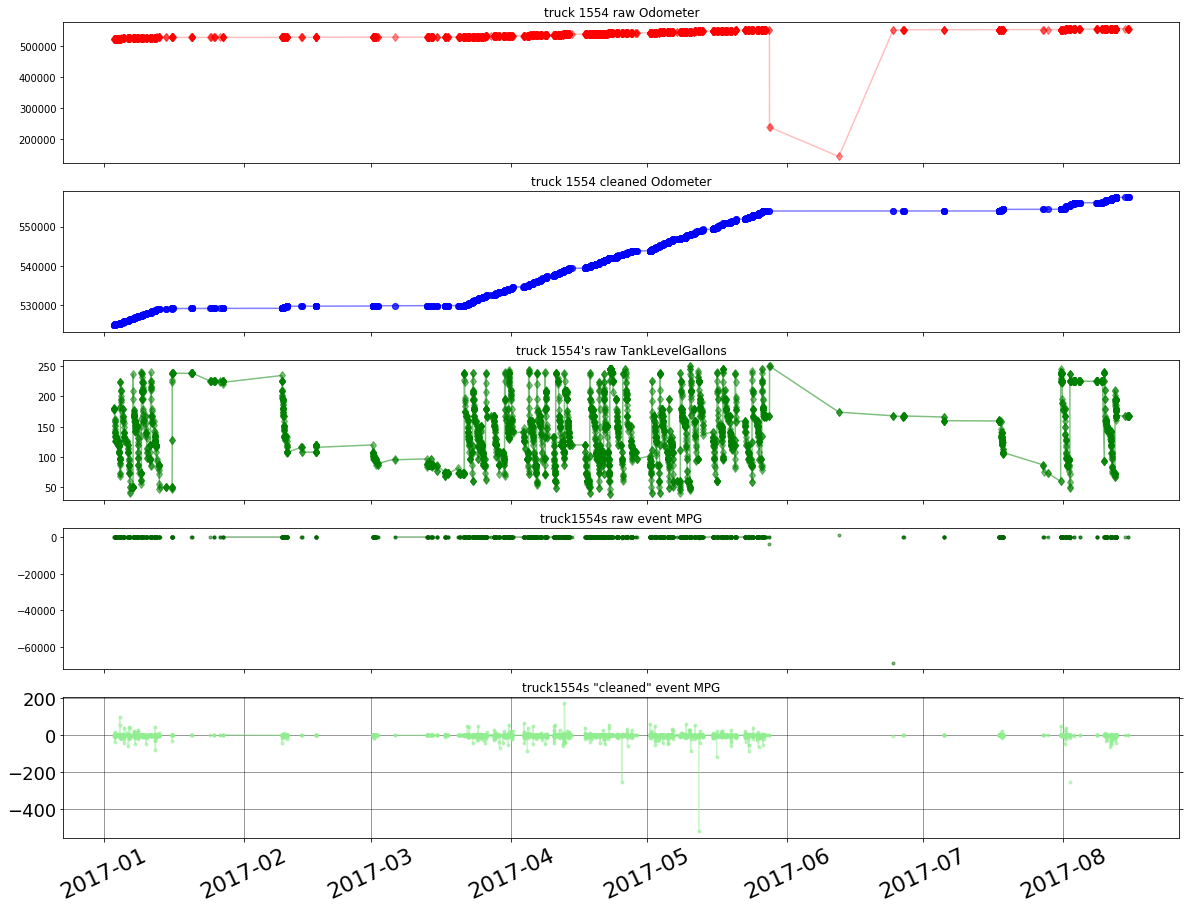

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1558 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  10289.79

------
Truck  1558 has had  11 drivers.
And they are:  {nan, 'DAVJO', 'JENCA', 'LUCJ', 'NOELA', 'HATA', 'SHOP1', 'ALBJ', 'HELB', 'DIXGR', 'PETL'}


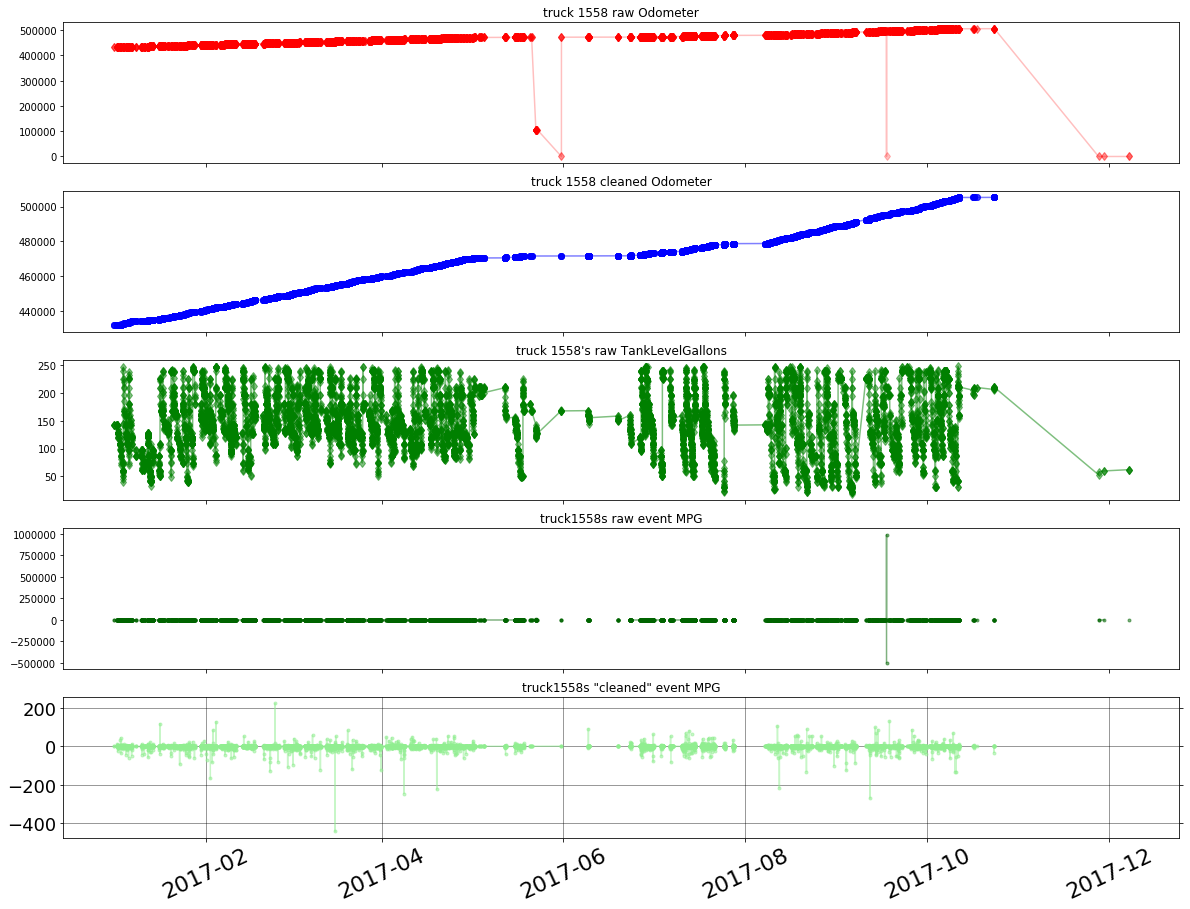

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1565 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  5395.56

------
Truck  1565 has had  5 drivers.
And they are:  {nan, 'FISJ', 'PAGC', 'SHOP1', 'BAYJ'}


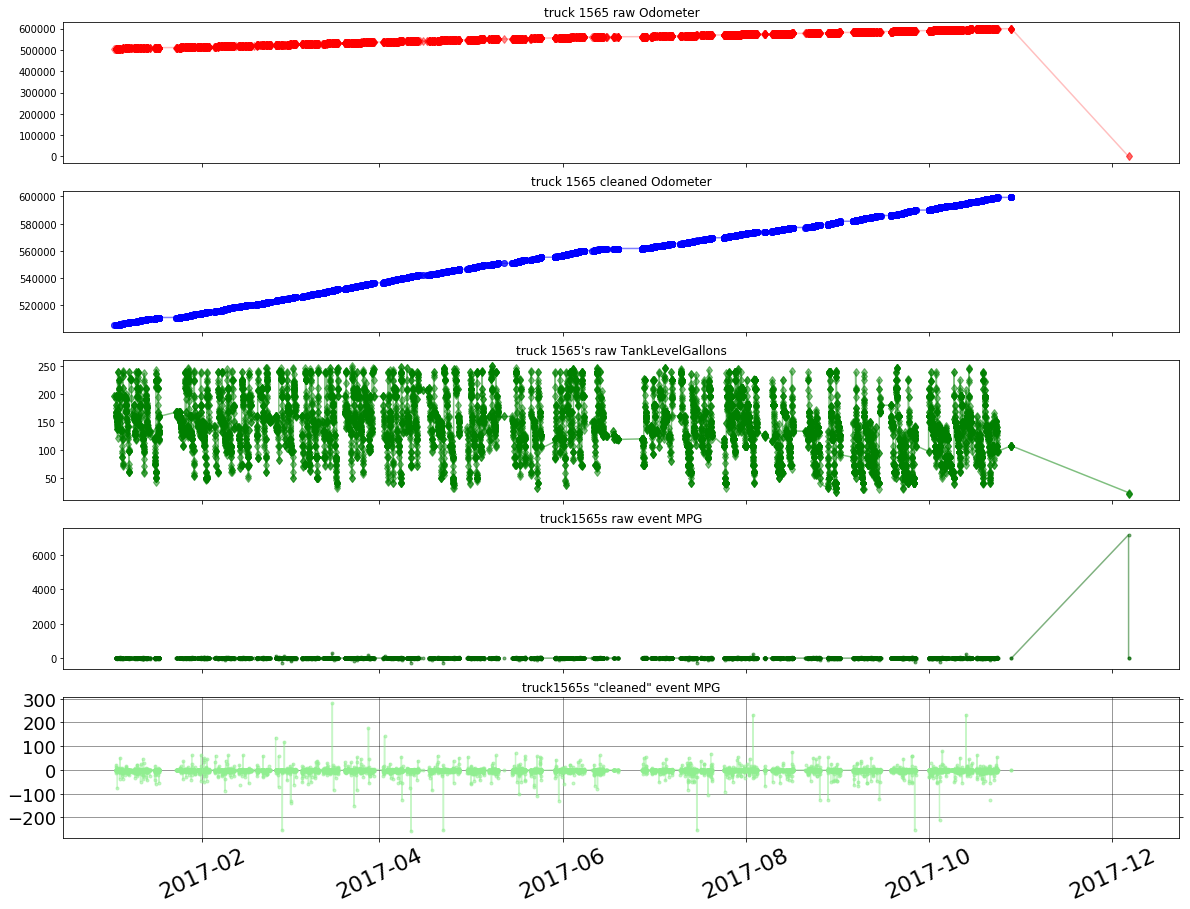

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1572 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  5971.15

------
Truck  1572 has had  5 drivers.
And they are:  {nan, 'ADAR', 'LANWA', 'TALM', 'BRARAY'}


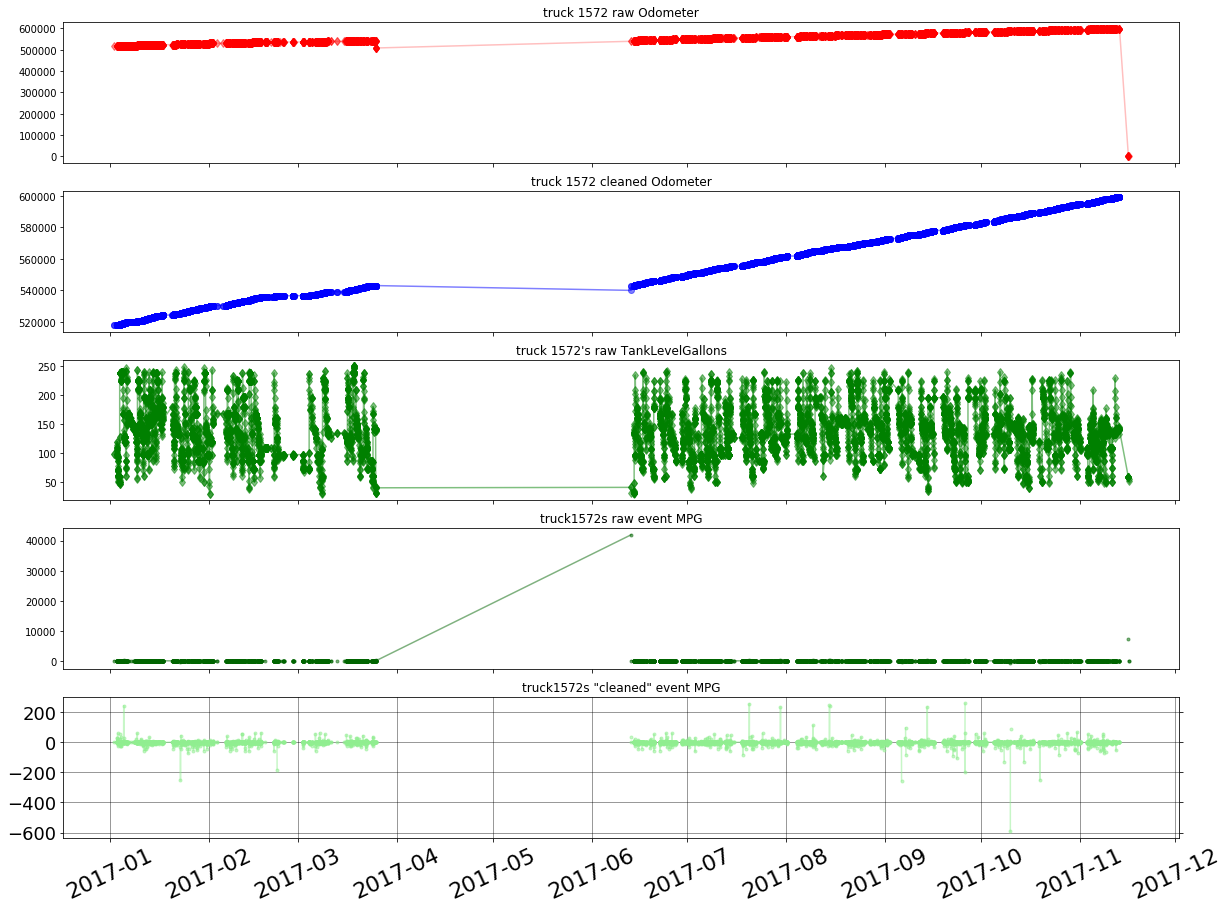

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1579 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  5680.95

------
Truck  1579 has had  8 drivers.
And they are:  {nan, 'WARDA', 'CLIJ', 'POGB', 'GODJ', 'DANR', 'JACCE', 'CLEWI'}


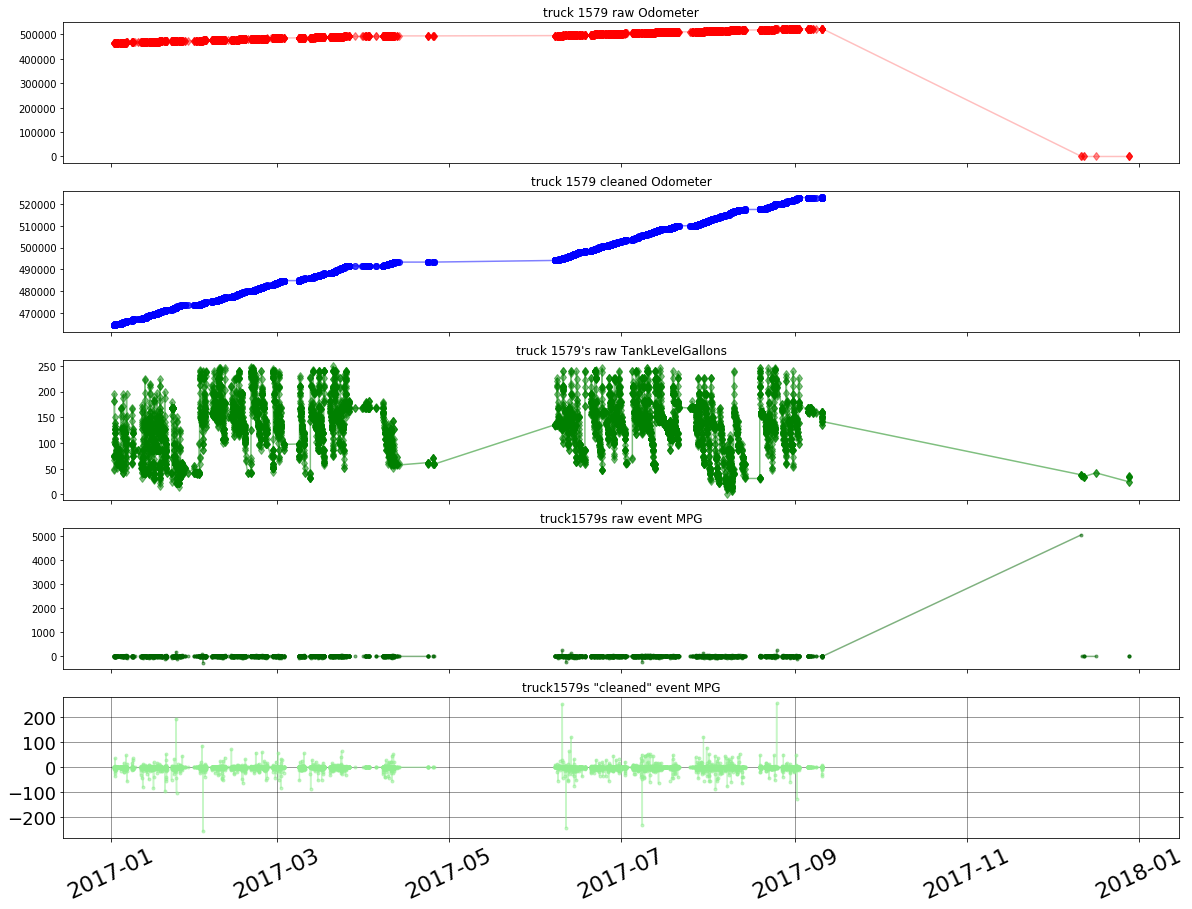

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1580 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  9946.71

------
Truck  1580 has had  20 drivers.
And they are:  {nan, 'GOOA', 'ROSE', 'FRYR', 'HILB', 'BROD03', 'WARDA', 'WILGEO', 'SHATHO', 'BULR', 'MEID', 'ARNMA', 'SHOP1', 'FELC', 'SMIGA', 'GRAJOH', 'HARWI', 'BELT', 'GUSC', 'LAYJ'}


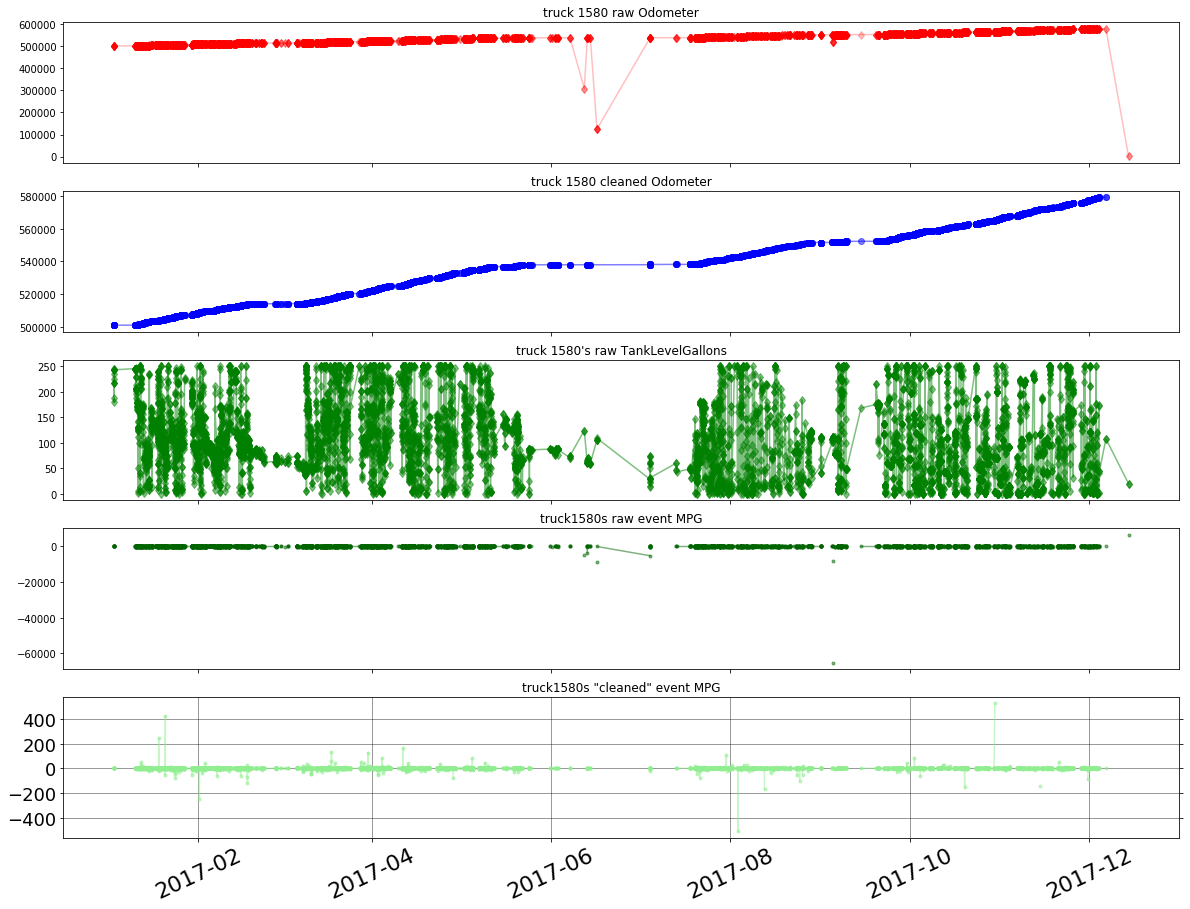

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1582 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  15950.49

------
Truck  1582 has had  8 drivers.
And they are:  {nan, 'HILB', 'SMID', 'DAVCA', 'ESTD', 'SHOP1', 'SHAMAR', 'HUFAU'}


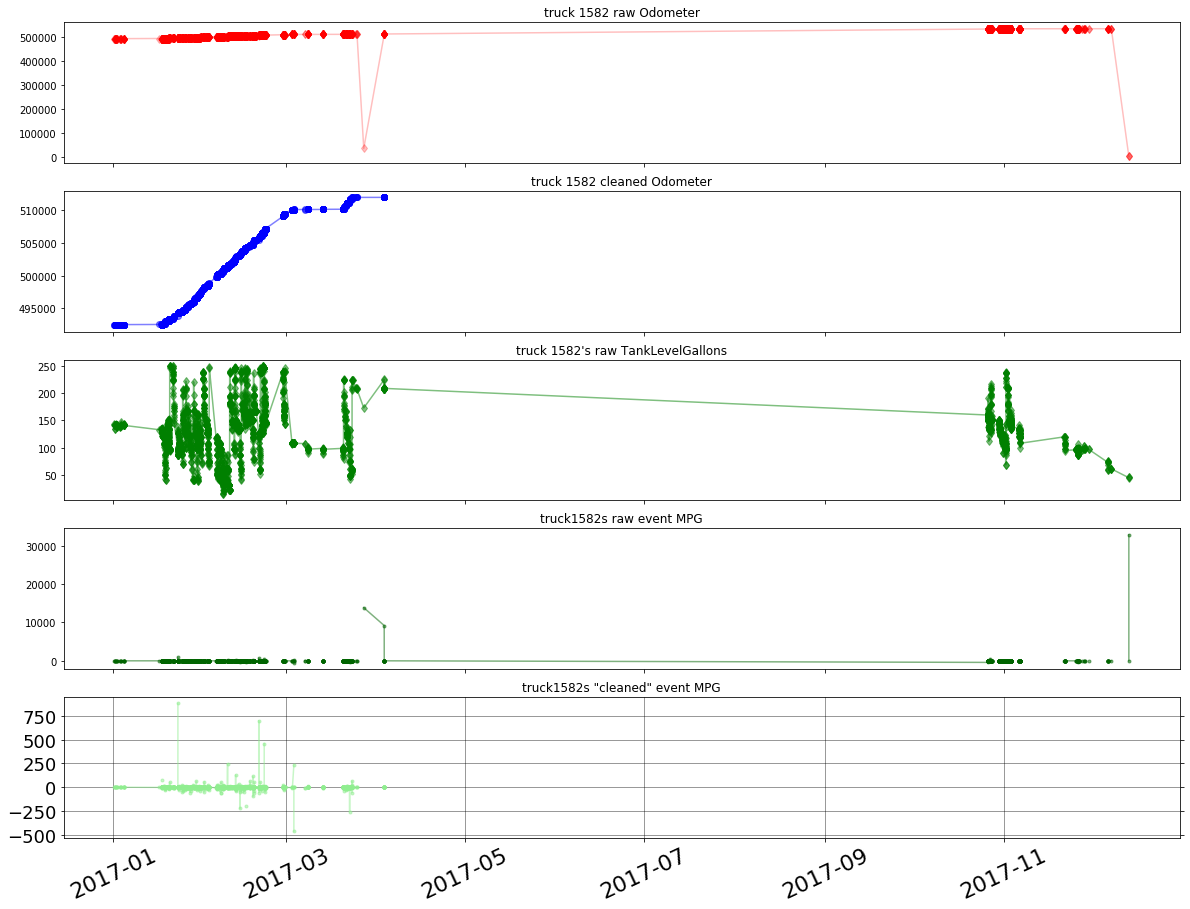

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1597 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  5135.77

------
Truck  1597 has had  10 drivers.
And they are:  {nan, 'HARKEV', 'JOHTE', 'THOMIC', 'BRERI', 'FRACH', 'SHOP1', 'WHIGR', 'STRAND', 'LOUR'}


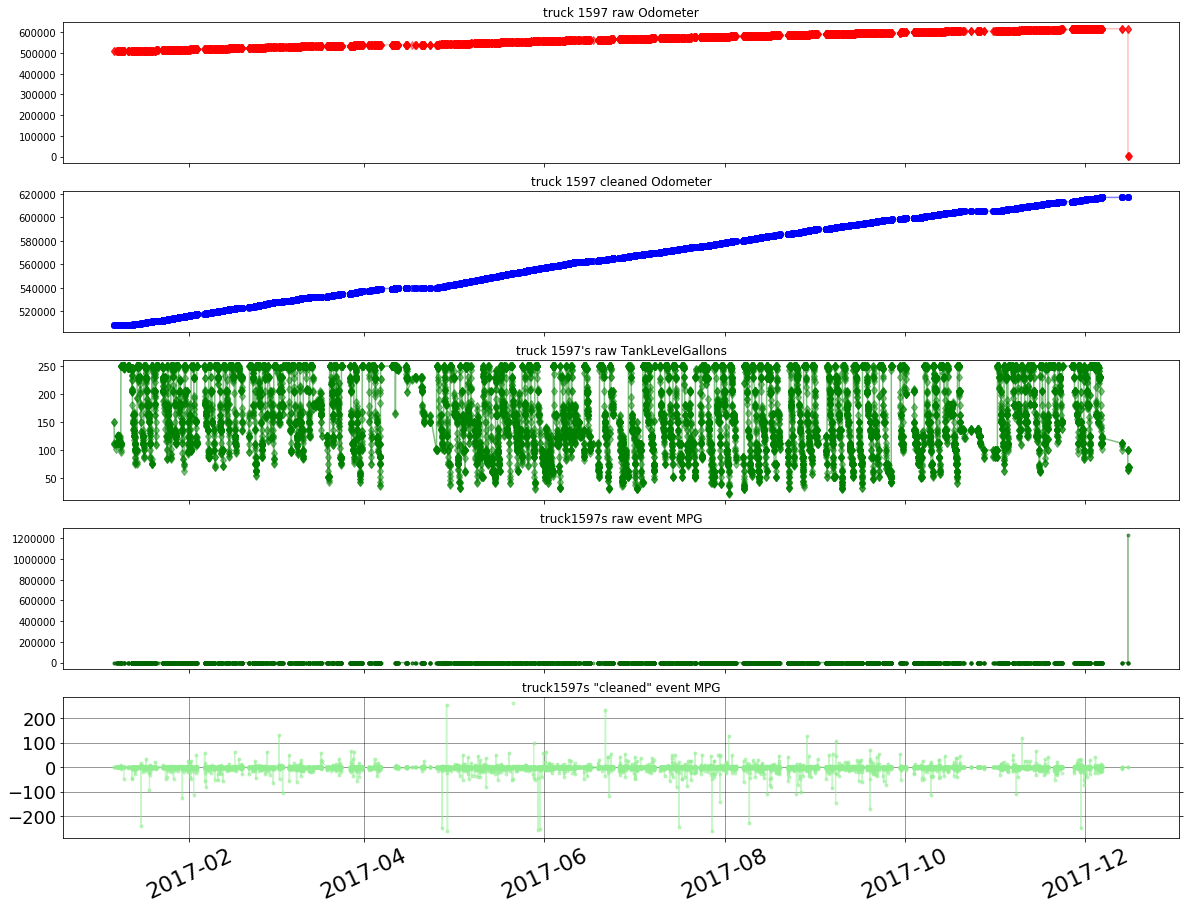

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1598 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  6408.38

------
Truck  1598 has had  10 drivers.
And they are:  {nan, 'MANBE', 'PERAL', 'RIFJ', 'MORI', 'SHOP1', 'THODAN', 'CRAMI', 'OVEM', 'GIBJ'}


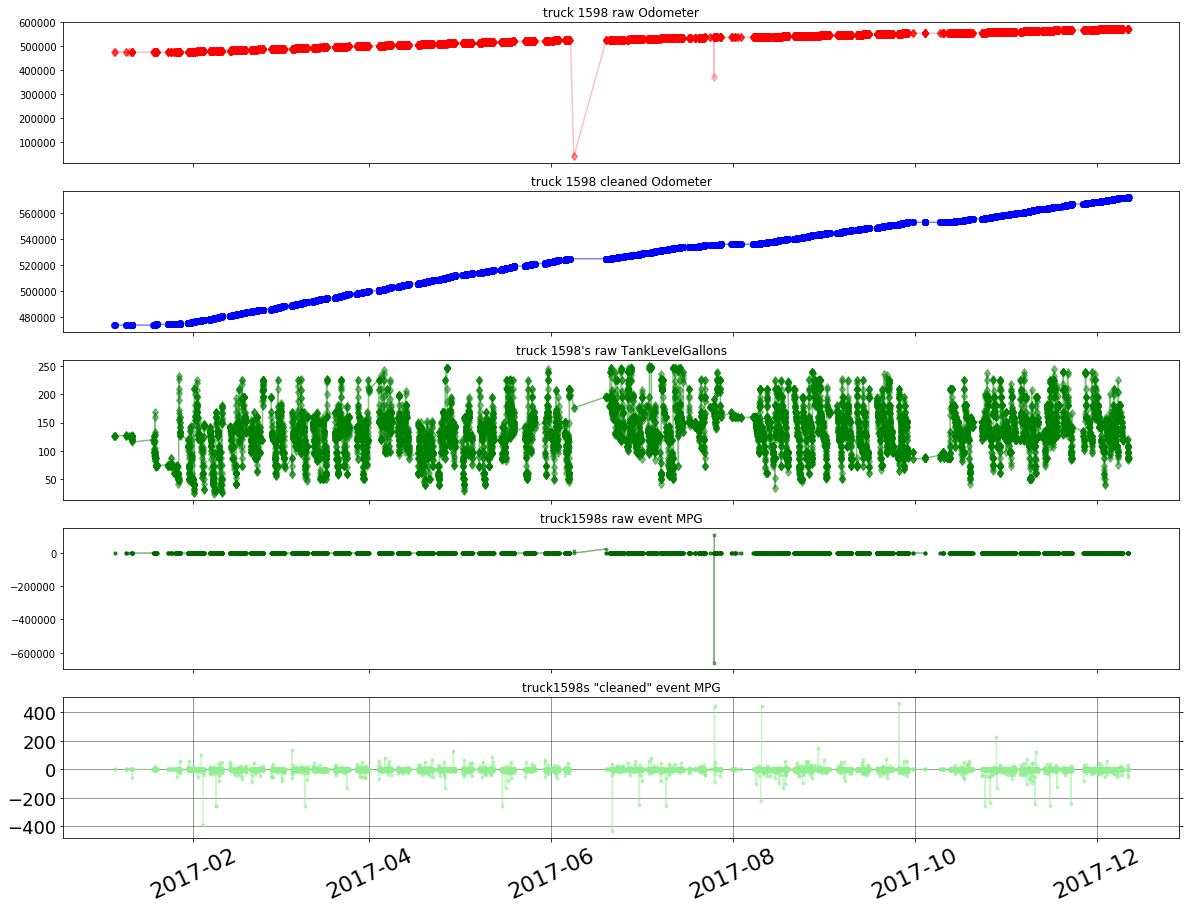

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1599 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  5179.25

------
Truck  1599 has had  4 drivers.
And they are:  {nan, 'SHOP1', 'MORGA', 'QUID'}


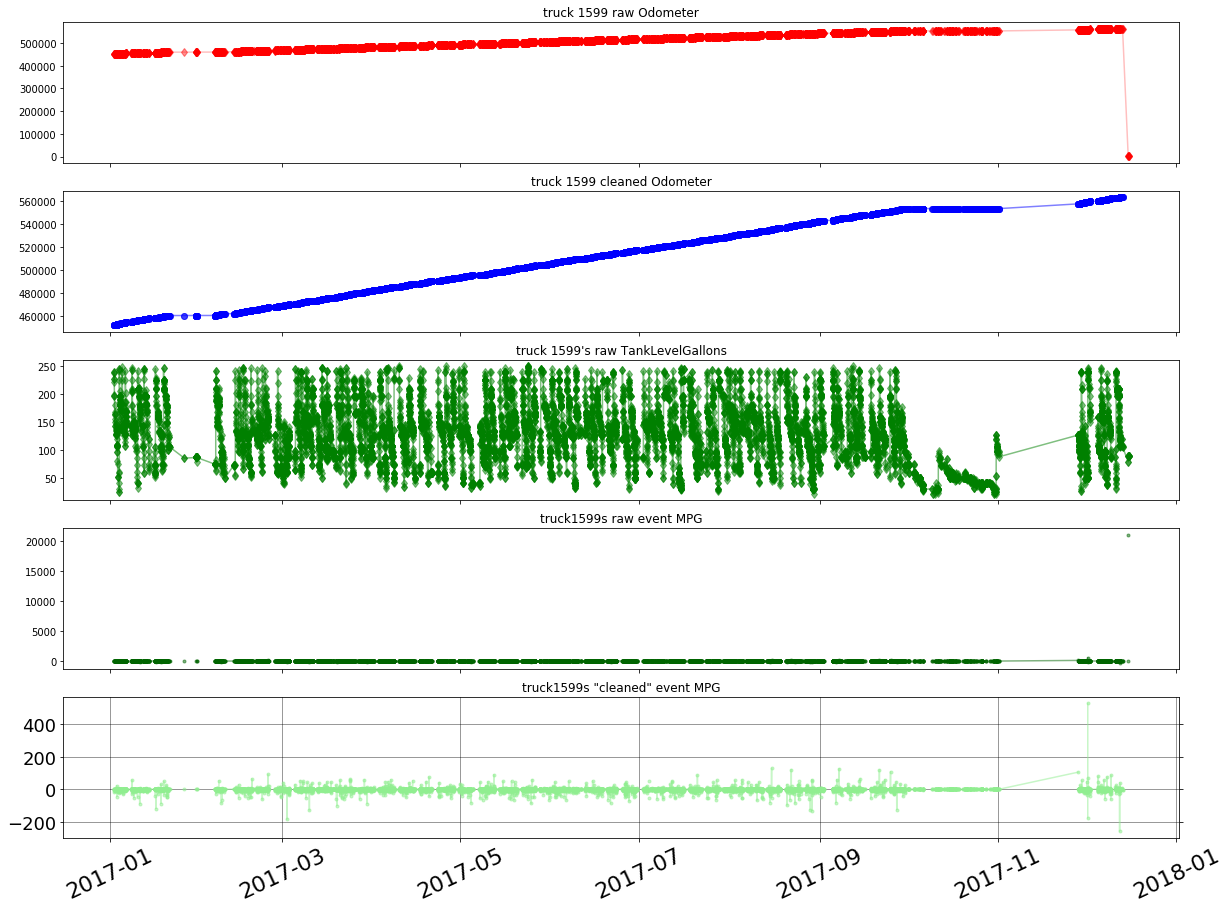

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1626 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  5329.31

------
Truck  1626 has had  5 drivers.
And they are:  {nan, 'NOEL', 'POGB', 'SIMDA', 'ROSE'}


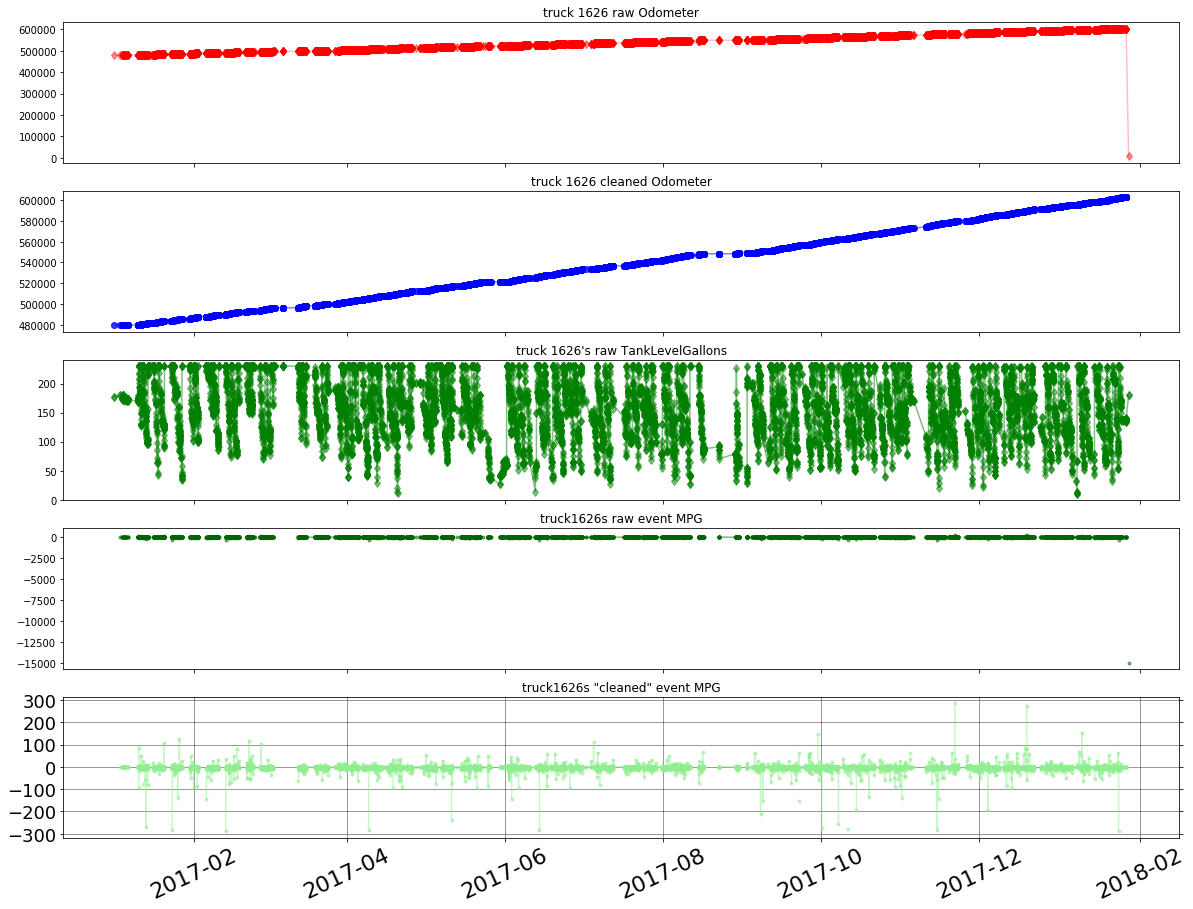

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1668 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  5849.66

------
Truck  1668 has had  8 drivers.
And they are:  {nan, 'SANJON', 'BARCR', 'DIXP', 'GREDAV', 'SHOP1', 'LUCM', 'DIXGR'}


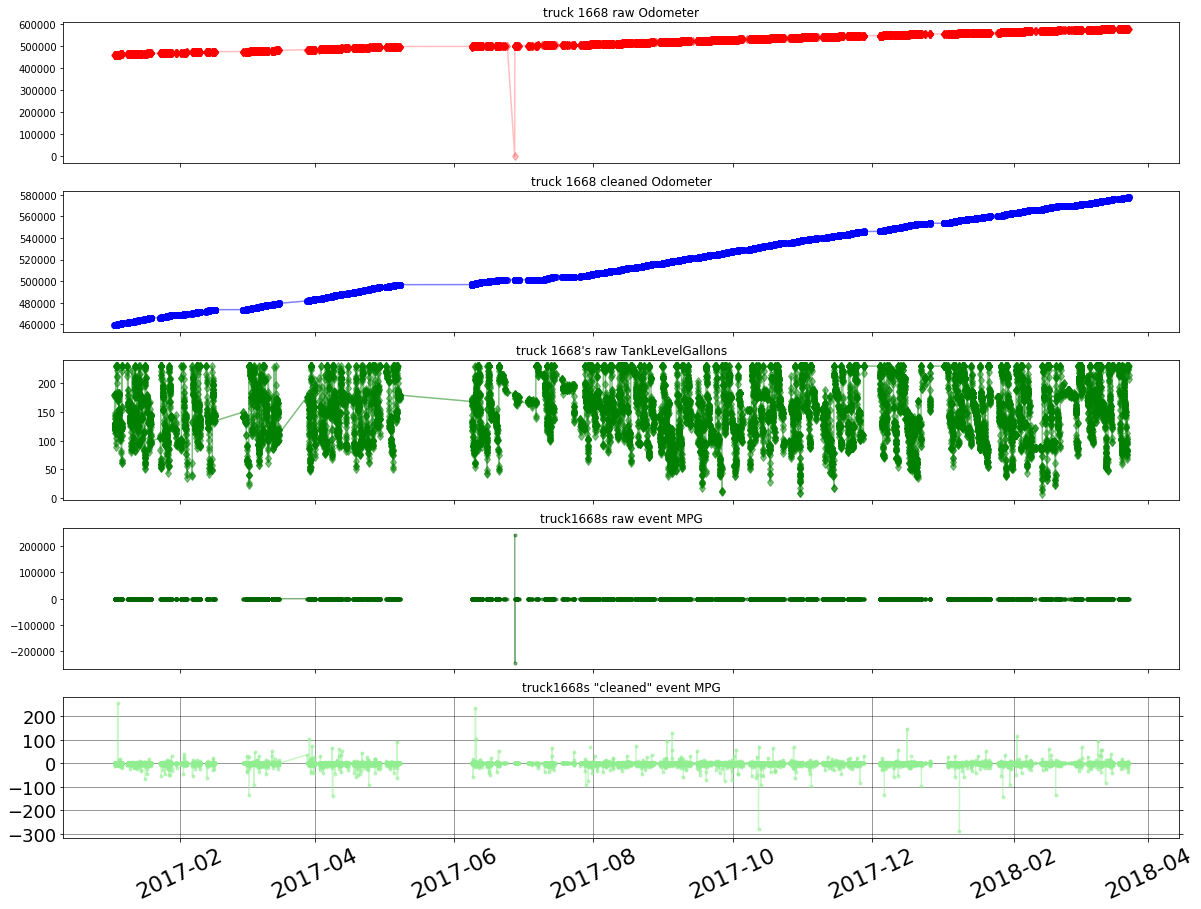

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1682 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  8048.17

------
Truck  1682 has had  7 drivers.
And they are:  {nan, 'FRAH', 'ROLRA', 'MAIK', 'CALBI', 'SHOP1', 'FLIE'}


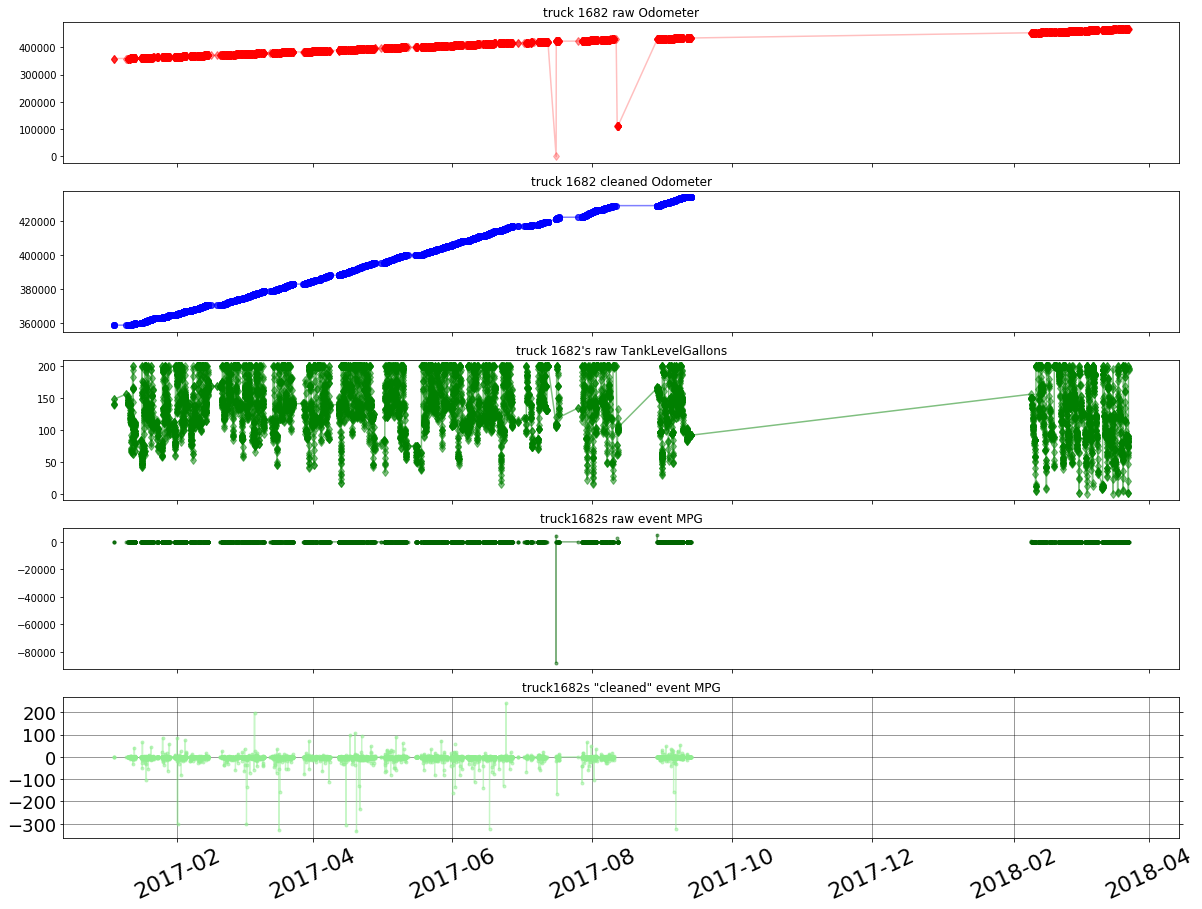

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1771 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  6370.72

------
Truck  1771 has had  8 drivers.
And they are:  {nan, 'ALSA', 'LAYJ', 'GUTJ', 'BURBO', 'PRUH', 'SHOP1', 'FELC'}


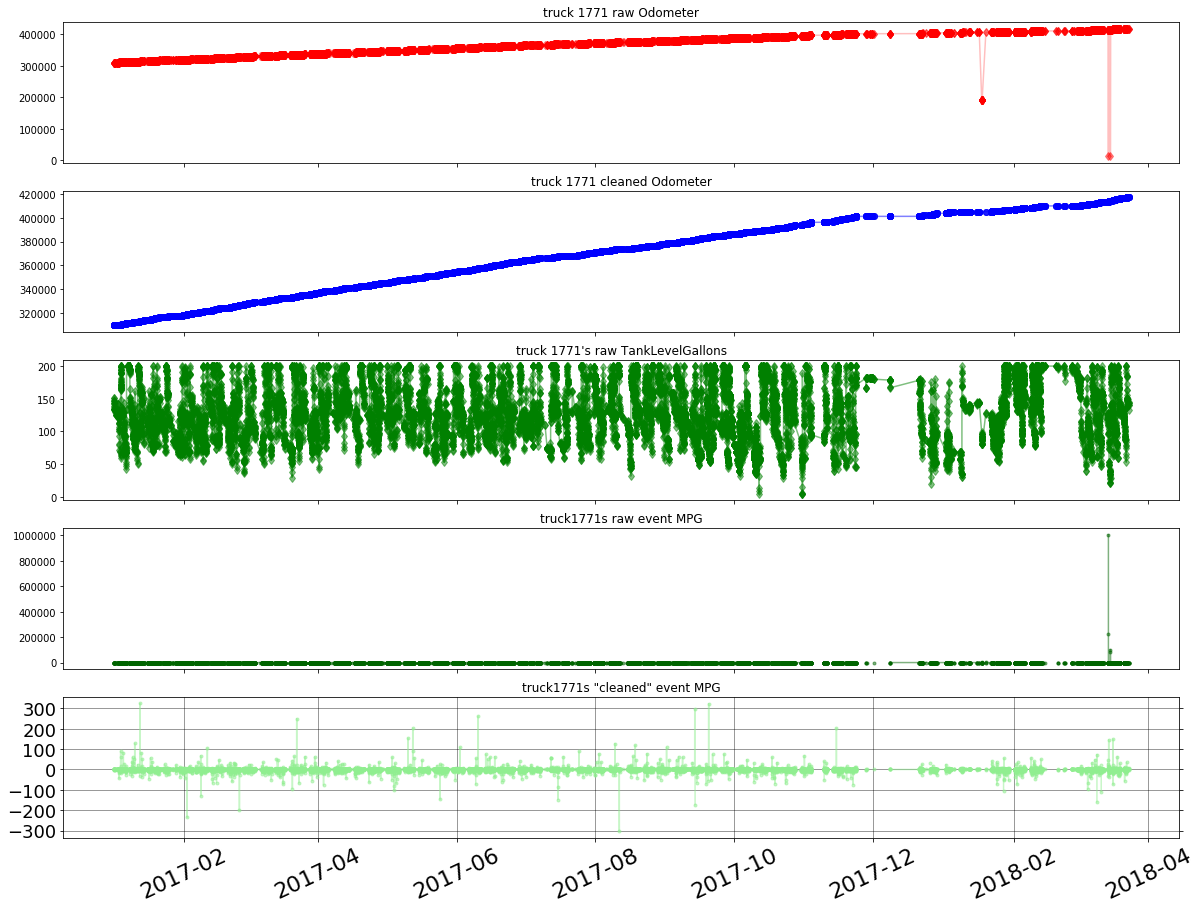

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1782 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  3585.07

------
Truck  1782 has had  4 drivers.
And they are:  {nan, 'MURJO', 'SHOP1', 'HAZSC'}


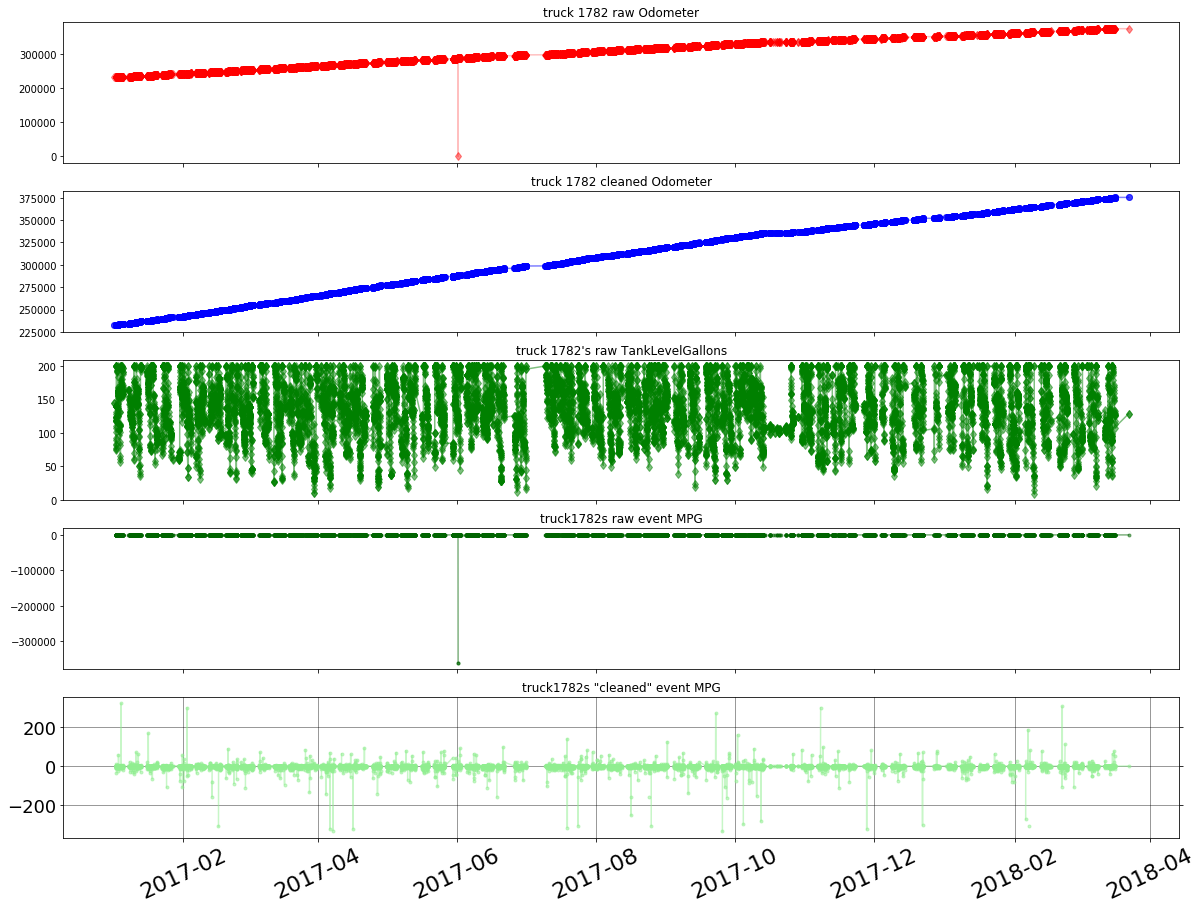

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1789 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  3429.01

------
Truck  1789 has had  8 drivers.
And they are:  {nan, 'KINROB', 'JONQ', 'PARW', 'GALH', 'WRIJON', 'DAVKE', 'BROTI'}


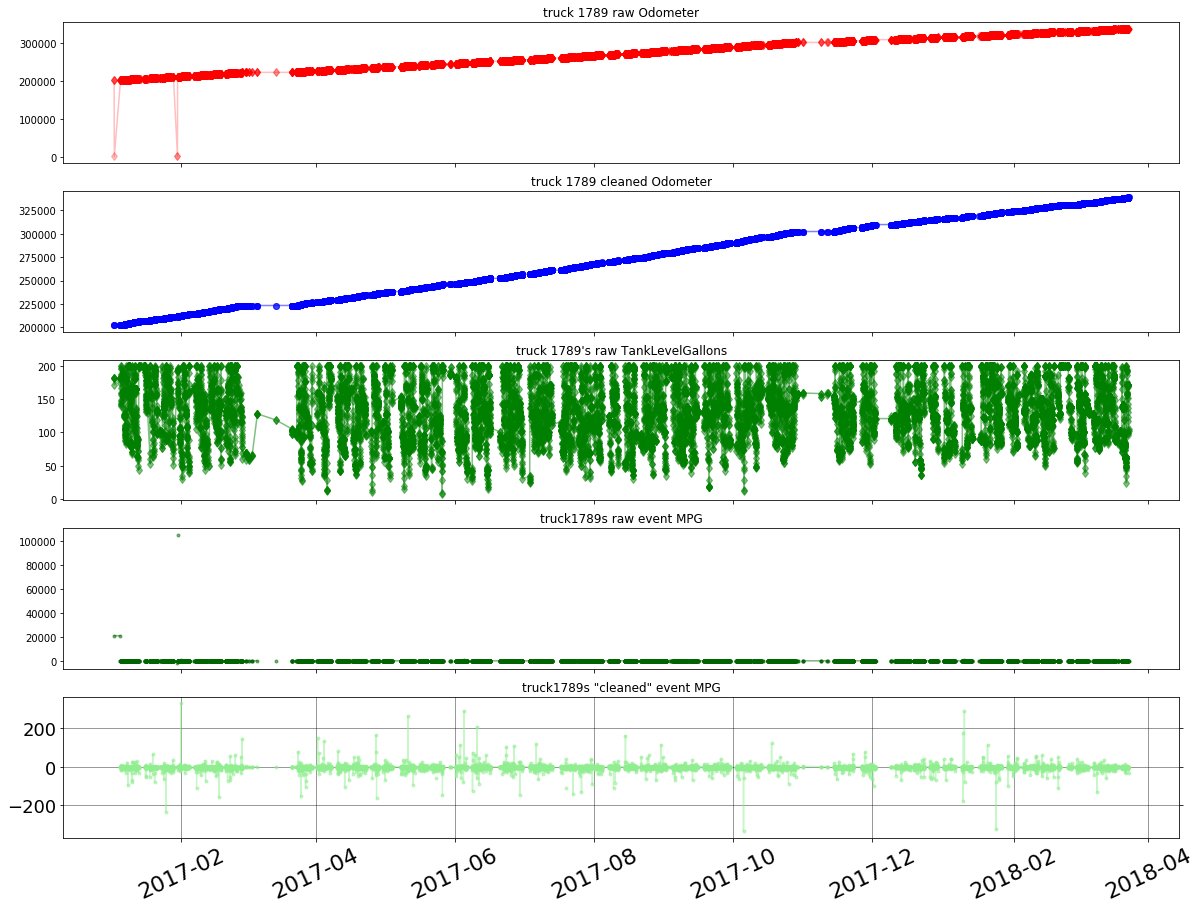

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1849 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  3512.64

------
Truck  1849 has had  4 drivers.
And they are:  {nan, 'PEIJ', 'GRAJOH', 'GLOJE'}


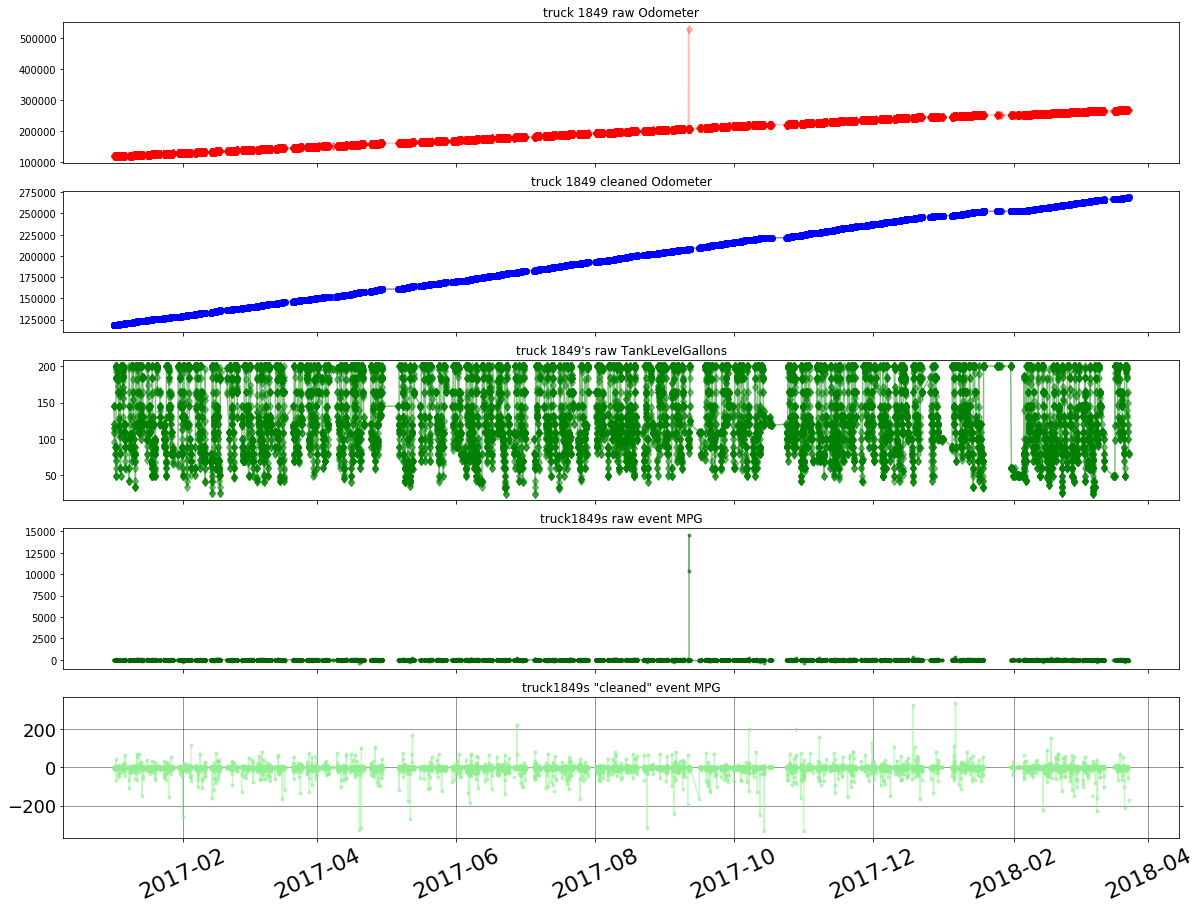

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1859 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  3579.43

------
Truck  1859 has had  3 drivers.
And they are:  {nan, 'EDWTI', 'WARDE'}


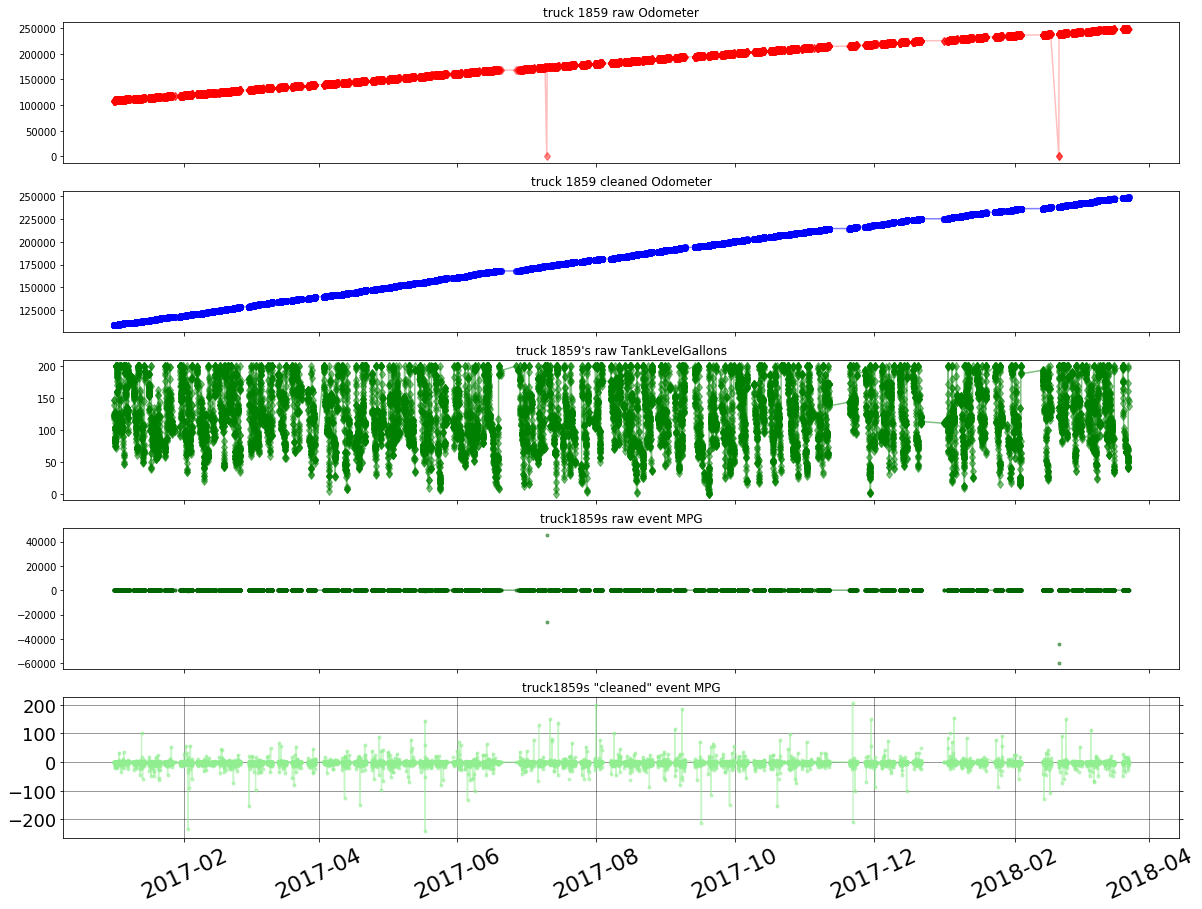

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1894 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  1108.09

------
Truck  1894 has had  4 drivers.
And they are:  {nan, 'BROTI', 'SHOP1', 'CHED'}


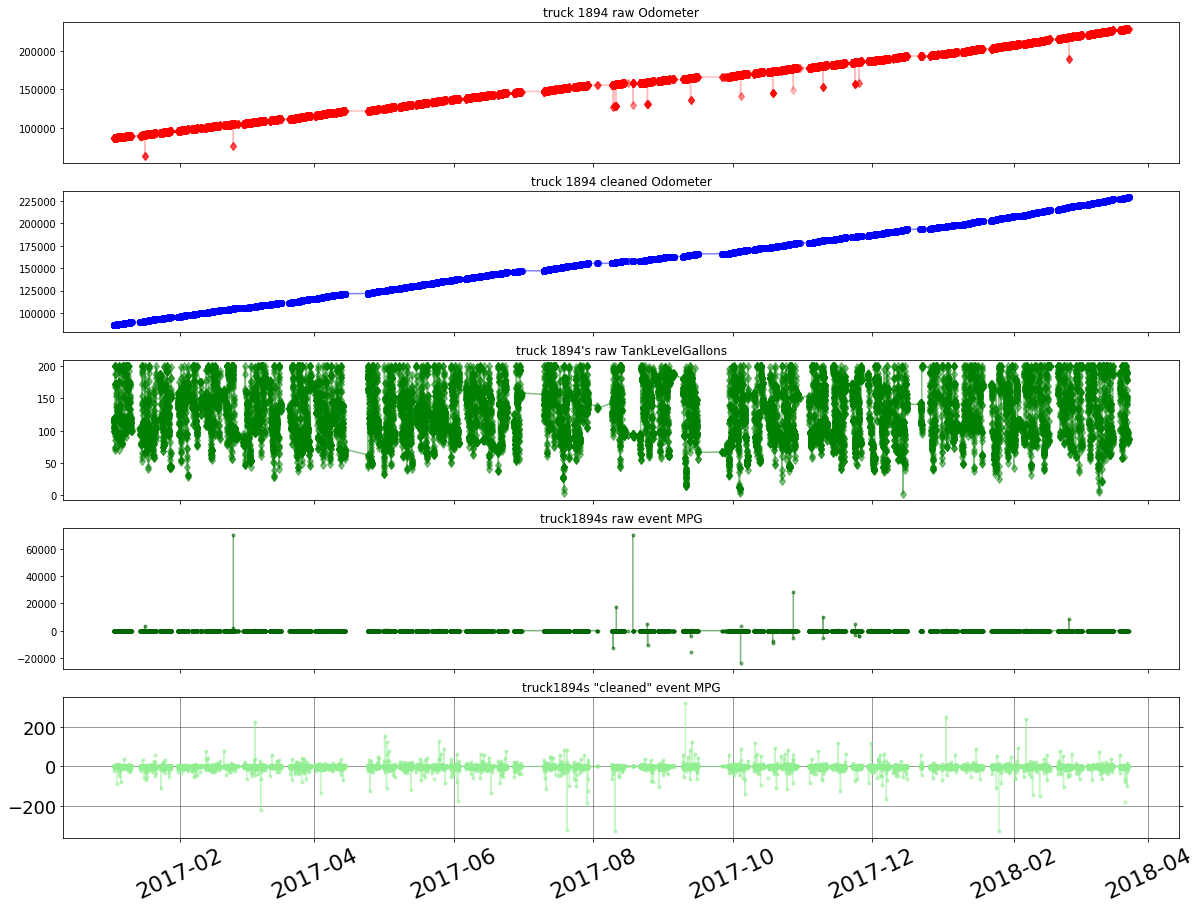

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1899 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  1027.53

------
Truck  1899 has had  2 drivers.
And they are:  {nan, 'NANP'}


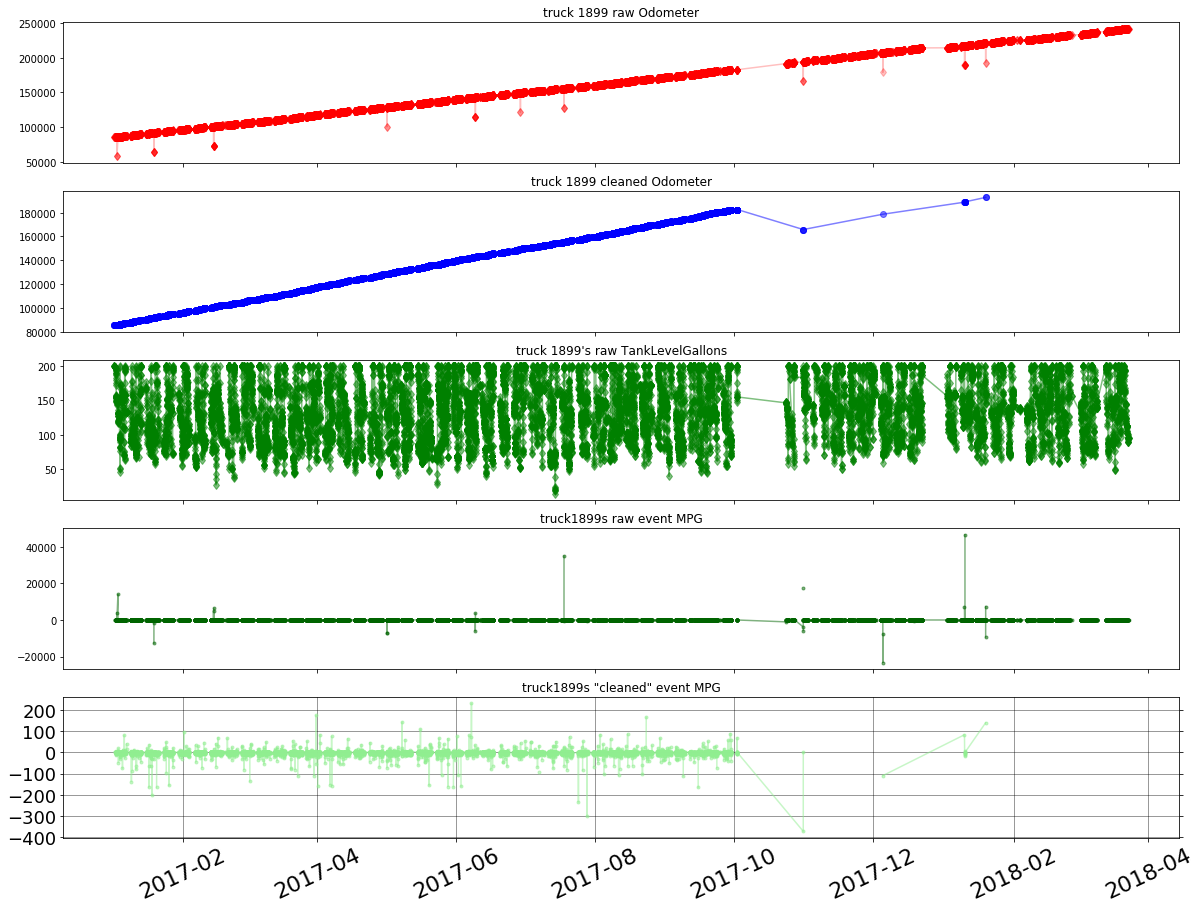

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1917 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  714.18

------
Truck  1917 has had  8 drivers.
And they are:  {nan, 'BOUB', 'OWESH', 'SHOP3', 'NORPA', 'DAVCA', 'CARD', 'SHOP1'}


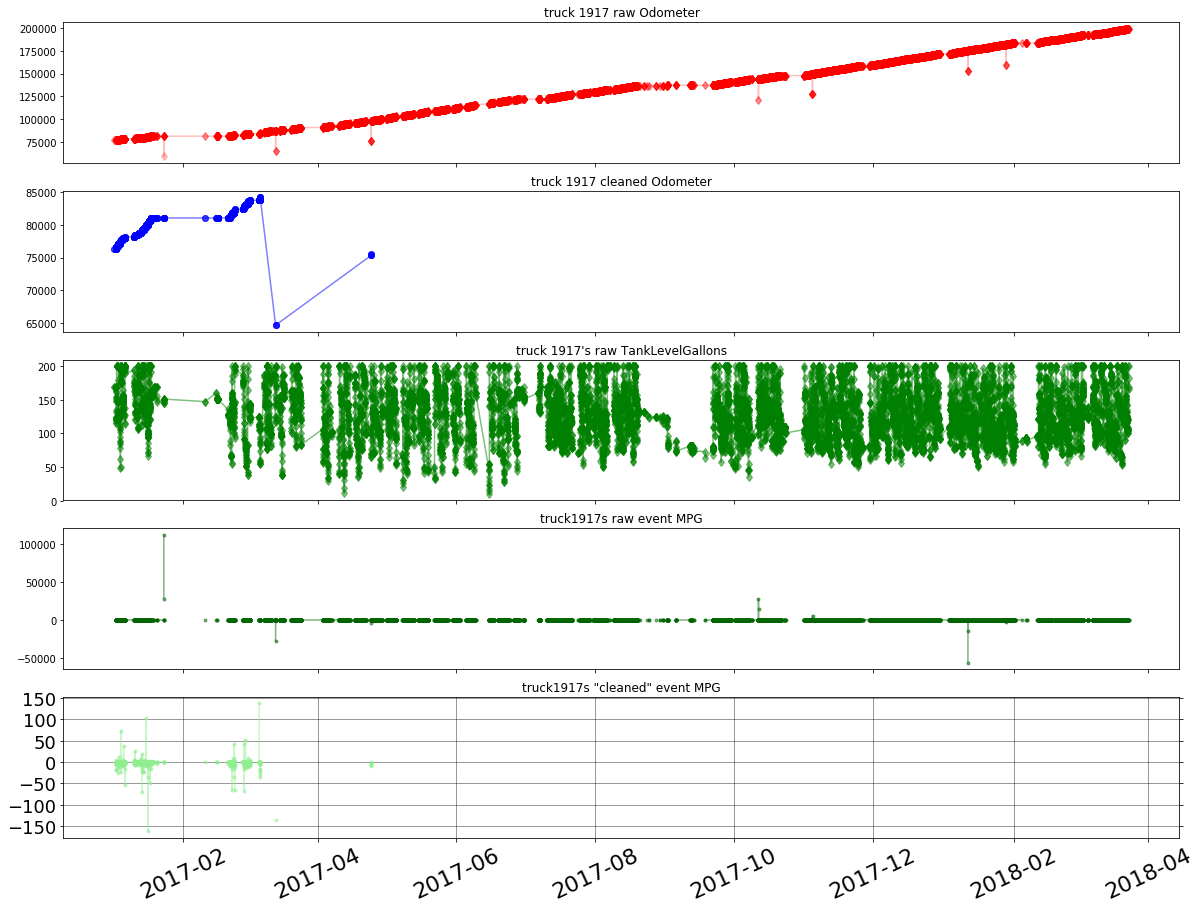

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1919 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  1822.25

------
Truck  1919 has had  2 drivers.
And they are:  {nan, 'BONZ'}


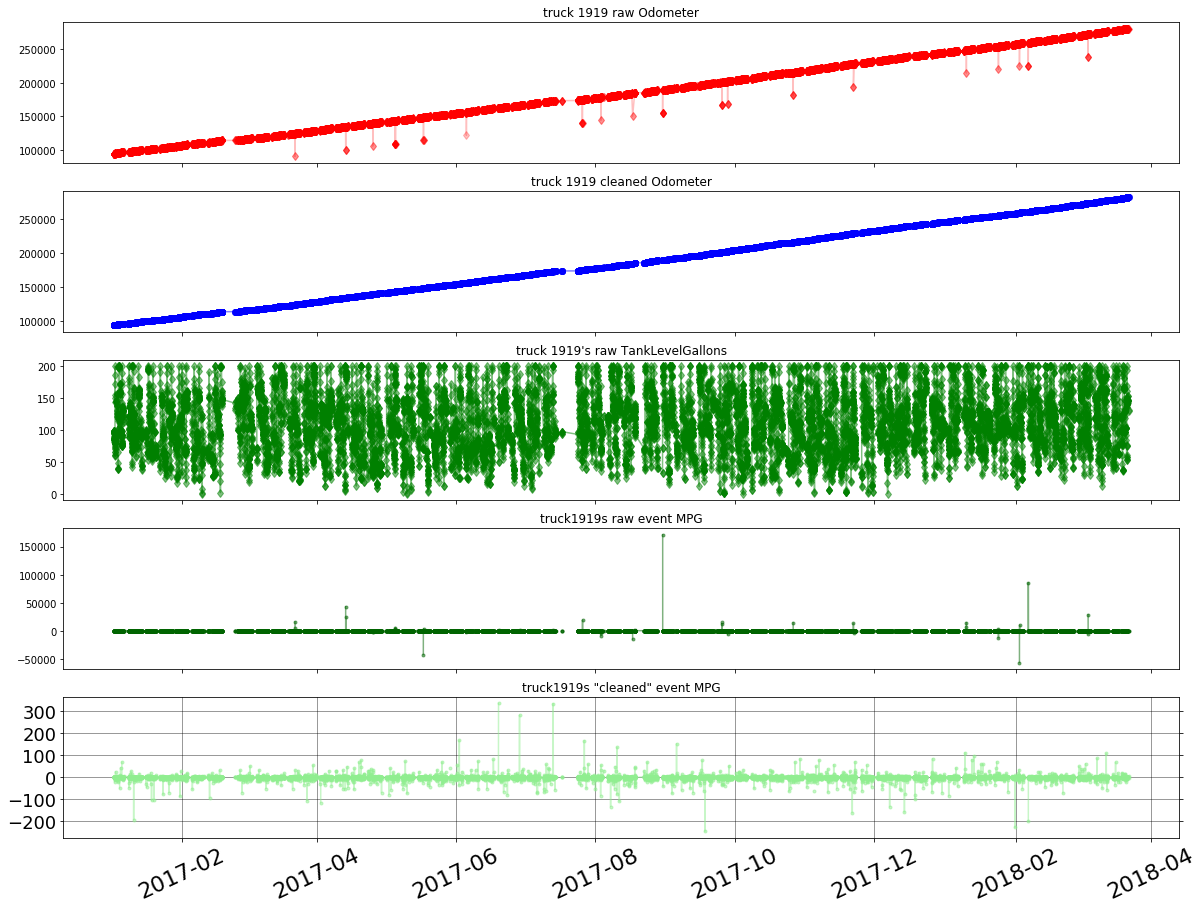

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1924 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  2615.73

------
Truck  1924 has had  3 drivers.
And they are:  {nan, 'HERV', 'GIBROY'}


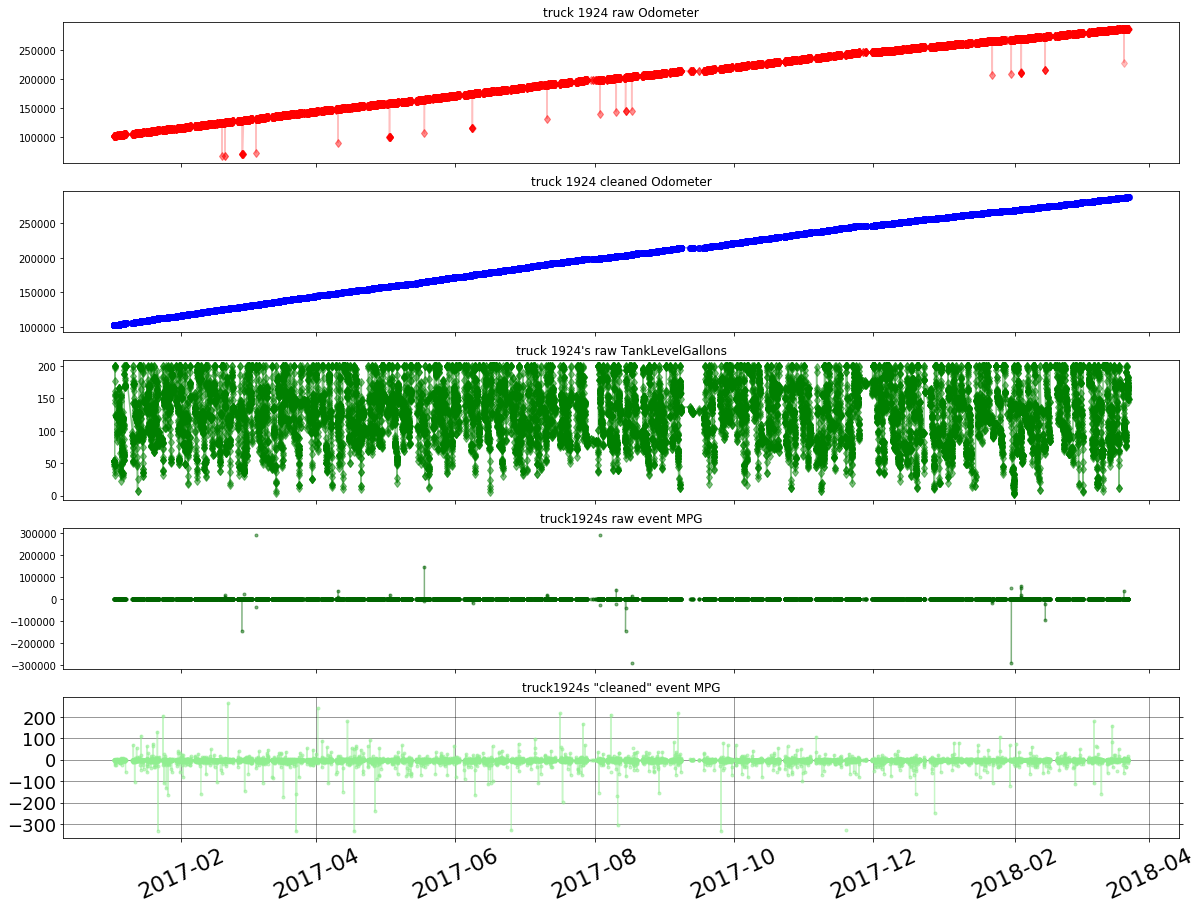

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1933 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  1918.71

------
Truck  1933 has had  4 drivers.
And they are:  {nan, 'LEVS', 'SHOP1', 'LARR'}


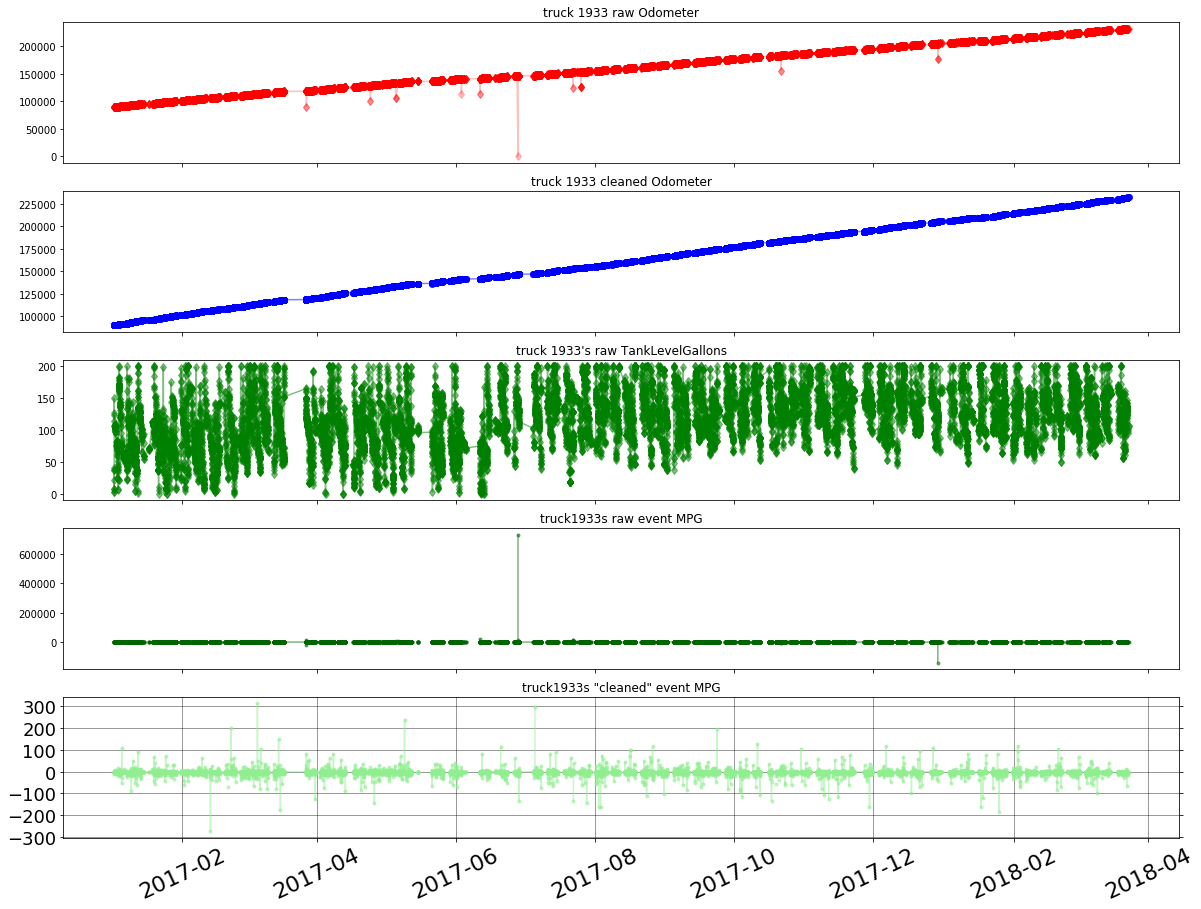

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1940 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  214.0

------
Truck  1940 has had  2 drivers.
And they are:  {nan, 'COOMI'}


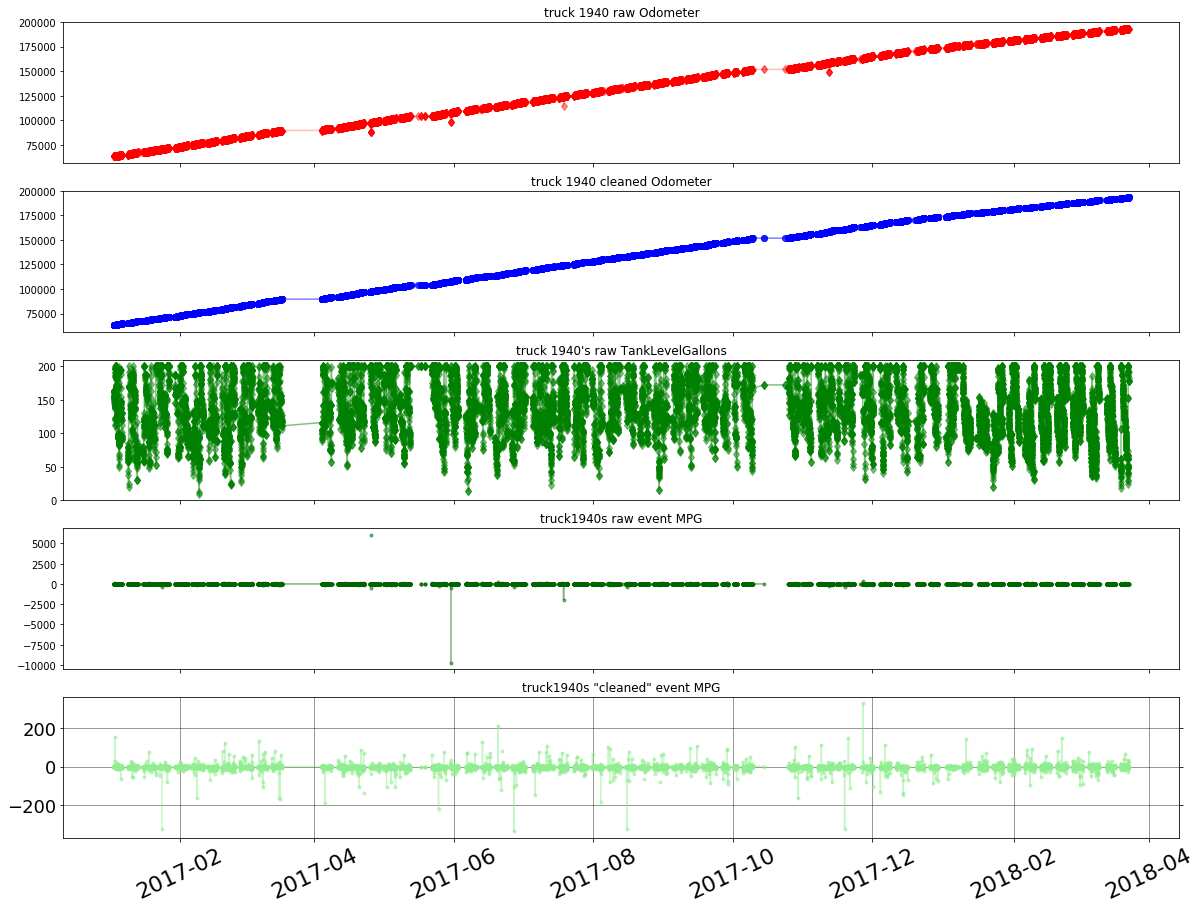

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 2011 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  4680.94

------
Truck  2011 has had  8 drivers.
And they are:  {nan, 'HODJE', 'SUTD', 'SHOP1', 'HERV', 'CLAMI', 'ELLTH', 'FREDA'}


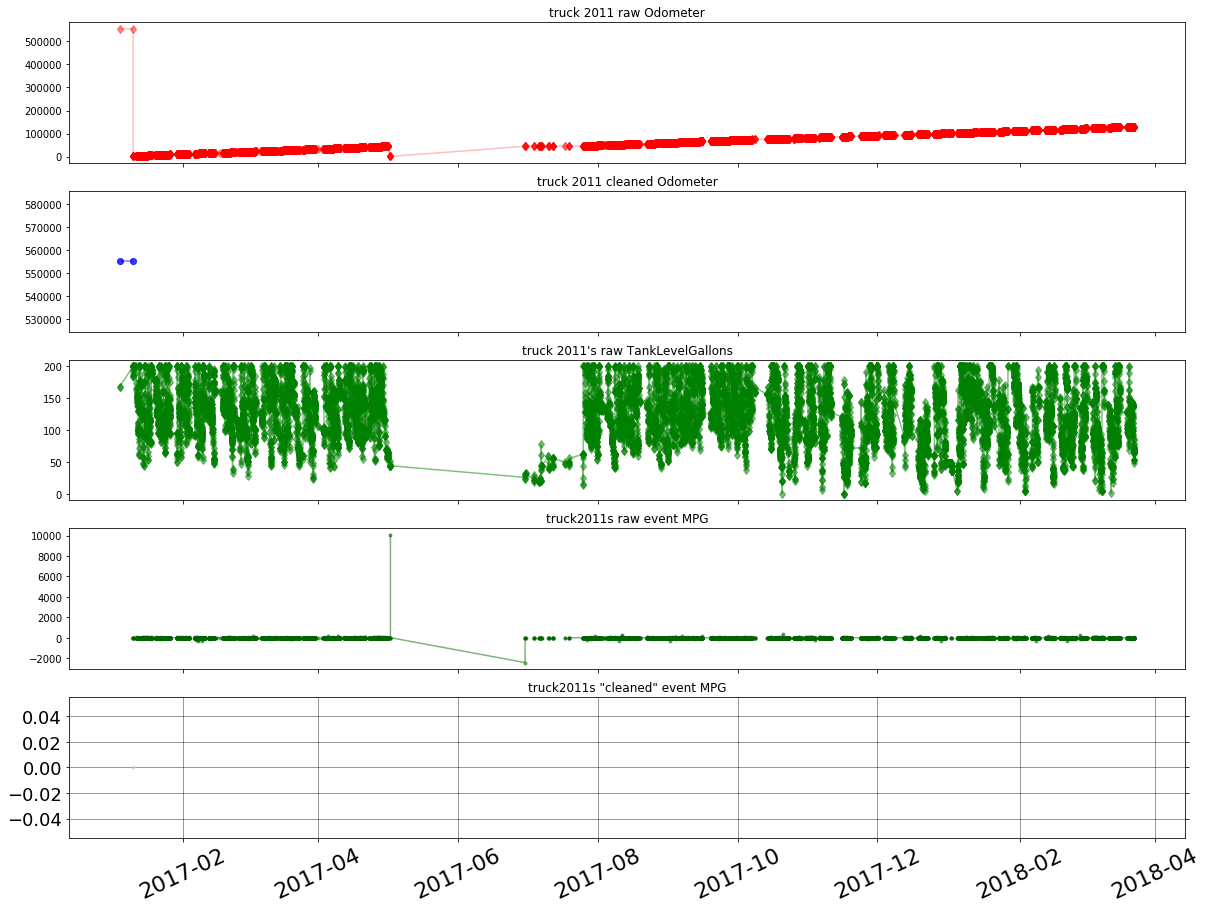

\----------------------------------------------------\/------------------------------------------------/


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 2099 ---------------------------------------------------\

-- set margin to Odometer.diff().std() =  771.0

------
Truck  2099 has had  3 drivers.
And they are:  {nan, 'GRAJU', 'SHOP1'}


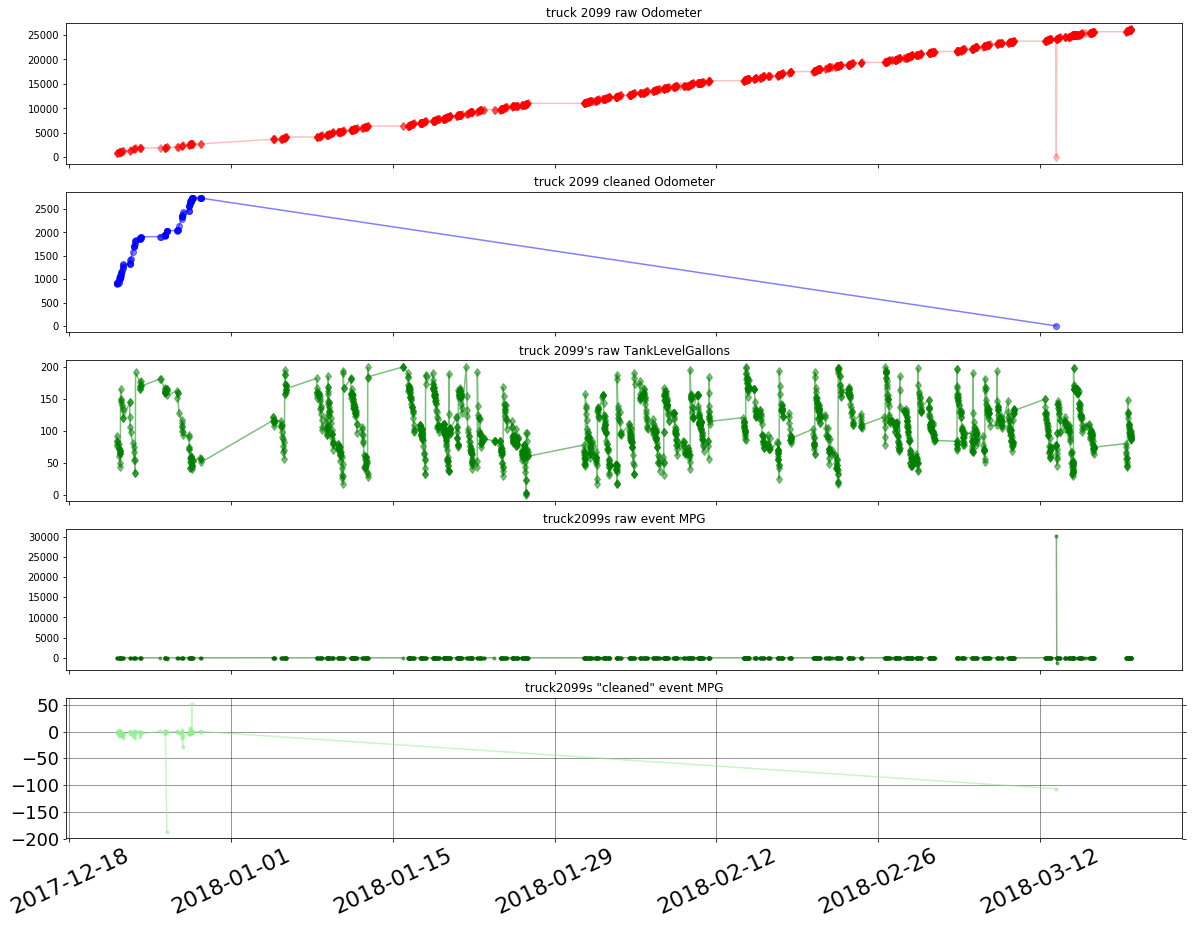

\----------------------------------------------------\/------------------------------------------------/



In [14]:
#for t in list(set(events_levels_df.truck)):
for t in troublesome_odometers:
    slice_clean_plot_2(events_levels_df, t, verbose = False, vigilant = False, interactive = False)

### breakdown of what is happening in the slice_clean_plot_2 function 
make a toy df, drop unecessary cols and reorder relevant ones

In [15]:
tr1554_events_levels_df = events_levels_df[events_levels_df.truck == 1554]
tr1554_events_levels_df.sort_values('EventTimeStamp', inplace = True)
tr1554_events_levels_df = tr1554_events_levels_df[flag_anomal_odom_rows_4(tr1554_events_levels_df, verbose = True, vigilant = True, interactive = False)]
tr1554_events_levels_df.head(2)

2018-05-07 15:44:17.282303 commencing flaging function (by reseting index).

-- set margin to Odometer.diff().std() =  8320.83

-- entering loop at  2018-05-07 15:44:17.283799
truck  1554  entered anomaly at i = 3468 2018-05-07 15:44:17.415813
truck  1554  exited anomaly at i= 3473 2018-05-07 15:44:17.416982
------------------
flagged  5 for removal.
That is:  0.12 % of  4001 raw rows.

With a margin of discrimination of :::::::::::::: 8320.83

print completed flagging function at  2018-05-07 15:44:17.437373 flagging took:  0:00:00.155074


/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Id          EventTimeStamp  EquipmentID DriverID  Latitude  \
0  12668252 2017-01-03 06:19:27.497         1554     HILF  38.35994   
1  12668282 2017-01-03 06:21:27.527         1554     HILF  38.35994   

   Longitude   LocationTimeStamp  Speed  Odometer IgnitionStatus  \
0  -81.73622 2017-01-03 06:19:30      0  524947.2              2   
1  -81.73622 2017-01-03 06:21:30      0  524947.2              2   

  EFReportReason  TankLevelPercent  TankLevelGallons  ExactFuelEventId  truck  \
0              1         72.099998            180.25          12668252   1554   
1              0         72.099998            180.25          12668282   1554   

   tankcap  
0      250  
1      250

In [16]:
# add my toy features

In [17]:
tr1554_events_levels_df['OdomDiff'] = tr1554_events_levels_df.Odometer.diff()

In [18]:
tr1554_events_levels_df['GallonsDiff'] = tr1554_events_levels_df.TankLevelGallons.diff()

In [19]:
tr1554_events_levels_df['event_mpg'] = [round(m/g, 2) for m, g in zip(tr1554_events_levels_df.OdomDiff,
                                                                        tr1554_events_levels_df.GallonsDiff)]

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [20]:
tr1554_events_levels_df.drop(['Id', 'EquipmentID', 'ExactFuelEventId'], axis = 1, inplace = True)

In [21]:
tr1554_events_levels_df = tr1554_events_levels_df[['EventTimeStamp', 'truck', 'DriverID', 'Odometer', 'OdomDiff',
                                                   'TankLevelGallons', 'GallonsDiff', 'event_mpg',
                                                   'Speed', 'Latitude', 'Longitude', 'TankLevelPercent','tankcap',
                                                   'IgnitionStatus', 'EFReportReason', 'LocationTimeStamp']]
tr1554_events_levels_df.reset_index(inplace = True, drop = True)
tr1554_events_levels_df.head()

EventTimeStamp  truck DriverID  Odometer  OdomDiff  \
0 2017-01-03 06:19:27.497   1554     HILF  524947.2       NaN   
1 2017-01-03 06:21:27.527   1554     HILF  524947.2       0.0   
2 2017-01-03 06:30:27.527   1554     HILF  524947.2       0.0   
3 2017-01-03 06:45:37.527   1554     HILF  524947.2       0.0   
4 2017-01-03 06:58:37.527   1554     HILF  524947.2       0.0   

   TankLevelGallons  GallonsDiff  event_mpg  Speed  Latitude  Longitude  \
0            180.25          NaN        NaN      0  38.35994  -81.73622   
1            180.25         0.00        NaN      0  38.35994  -81.73622   
2            179.75        -0.50       -0.0      0  38.35998  -81.73621   
3            180.00         0.25        0.0      0  38.35998  -81.73621   
4            180.00         0.00        NaN      0  38.35997  -81.73623   

   TankLevelPercent  tankcap IgnitionStatus EFReportReason   LocationTimeStamp  
0         72.099998      250              2              1 2017-01-03 06:19:30  
1         72.099998      250              2              0 2017-01-03 06:21:30  
2         71.900002      250              1              0 2017-01-03 06:30:30  
3         72.000000      250              1              2 2017-01-03 06:45:40  
4         72.000000      250              2              1 2017-01-03 06:58:40

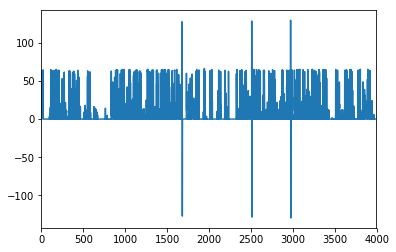

In [22]:
## inspect results
tr1554_events_levels_df.OdomDiff.plot()
plt.show()

Looks like ther are some smaller anomalies (with their corrections) going on in the Odometer. Specifically the notice the negative ones, and the ones with magnitude greater than 75

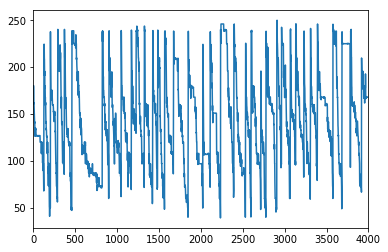

In [23]:
tr1554_events_levels_df.TankLevelGallons.plot()
plt.show()

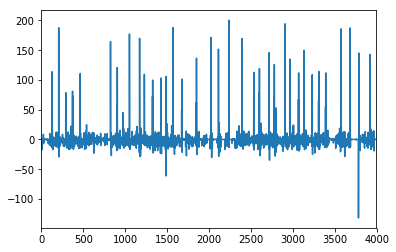

In [24]:
tr1554_events_levels_df.GallonsDiff.plot()
plt.show()

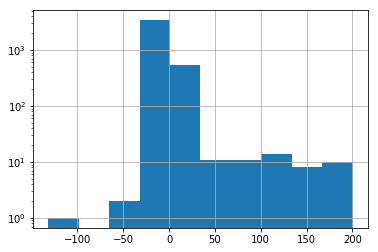

In [25]:
tr1554_events_levels_df.GallonsDiff.hist(log = True)
plt.show()

In [26]:
tr1554_events_levels_df[['Odometer', 'OdomDiff', 'TankLevelGallons', 'GallonsDiff', 
                         'event_mpg']][abs(tr1554_events_levels_df.event_mpg) == np.inf]

Odometer  OdomDiff  TankLevelGallons  GallonsDiff  event_mpg
95    525250.1       3.7            120.00          0.0        inf
142   525639.0      10.2            179.75          0.0        inf
152   525878.6      11.0            140.25          0.0        inf
167   526110.6       4.2            108.00          0.0        inf
173   526112.0       0.7            119.50          0.0        inf
212   526721.9       0.4            168.00          0.0        inf
213   526722.1       0.2            168.00          0.0        inf
271   527224.3       2.0             97.75          0.0        inf
272   527286.0      61.7             97.75          0.0        inf
299   527436.6       9.0            224.25          0.0        inf
388   528468.9       1.7            167.75          0.0        inf
421   528787.2      11.0            120.00          0.0        inf
422   528814.5      27.3            120.00          0.0        inf
493   529205.4       0.2            224.75          0.0        inf
566   529539.8       0.3            133.50          0.0        inf
567   529540.0       0.2            133.50          0.0        inf
588   529782.5       0.3            108.00          0.0        inf
753   529890.7       0.2             87.00          0.0        inf
832   529940.9       7.0            237.75          0.0        inf
997   531926.5      12.8            119.50          0.0        inf
1000  531936.9       0.1            120.00          0.0        inf
1008  531938.9       0.5            119.25          0.0        inf
1111  532946.1       0.5            121.00          0.0        inf
1114  532950.9       0.2            120.25          0.0        inf
1119  532953.4       0.3            119.50          0.0        inf
1163  533526.8       0.3             87.00          0.0        inf
1181  533808.5       1.6            195.75          0.0        inf
1229  534091.2       0.1            239.00          0.0        inf
1267  534437.3       0.1            162.00          0.0        inf
1274  534625.4      61.8            142.25          0.0        inf
...        ...       ...               ...          ...        ...
3719  555970.0       0.3            225.00          0.0        inf
3721  555970.3       0.3            225.00          0.0        inf
3724  555980.9      10.6            225.00          0.0        inf
3725  555990.6       9.7            225.00          0.0        inf
3726  556007.8      17.2            225.00          0.0        inf
3727  556015.1       7.3            225.00          0.0        inf
3728  556029.1      14.0            225.00          0.0        inf
3729  556041.9      12.8            225.00          0.0        inf
3730  556051.6       9.7            225.00          0.0        inf
3733  556051.7       0.1            225.00          0.0        inf
3735  556051.8       0.1            225.00          0.0        inf
3738  556052.2       0.4            225.00          0.0        inf
3745  556052.4       0.2            225.00          0.0        inf
3752  556052.6       0.2            225.00          0.0        inf
3765  556052.8       0.1            225.00          0.0        inf
3767  556052.9       0.1            225.00          0.0        inf
3768  556053.1       0.2            225.00          0.0        inf
3776  556053.4       0.3            225.00          0.0        inf
3777  556065.0      11.6            225.00          0.0        inf
3778  556128.8      63.8            225.00          0.0        inf
3779  556193.1      64.3            225.00          0.0        inf
3780  556256.9      63.8            225.00          0.0        inf
3781  556288.8      31.9            225.00          0.0        inf
3782  556289.2       0.4            225.00          0.0        inf
3813  556586.2       0.2            160.00          0.0        inf
3882  556934.2       8.2            120.25          0.0        inf
3905  557162.9       0.1             73.00          0.0        inf
3936  557337.3       0.5            194.50          0

In [27]:
tr1554_events_levels_df[['Odometer', 'OdomDiff', 'TankLevelGallons', 'GallonsDiff', 
                         'event_mpg']][tr1554_events_levels_df.event_mpg == -np.inf]

Empty DataFrame
Columns: [Odometer, OdomDiff, TankLevelGallons, GallonsDiff, event_mpg]
Index: []

#### Notice there don't seem to be any negatively infinite values
apparently none of the noisy negative odometer differences ever paird up with a zero Gallons diff

#### Another way to handle the infinite mpgs is to aggregte the sum of deltas:
- by minute
- hour
- day
- week
- month

the aggregated sums will still somewhat polluted, but we can go back and clean the odometer and gallons collums if necessary

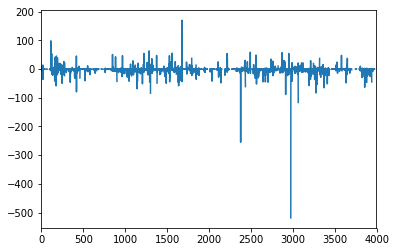

In [28]:
tr1554_events_levels_df.event_mpg.plot()
plt.show()

## Incomplete attempt to assign categorical colors with matplotlib

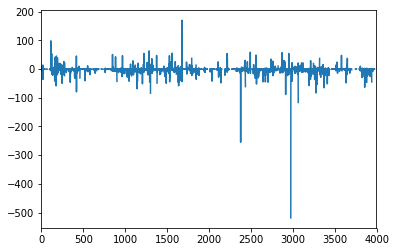

In [29]:
tr1554_events_levels_df.event_mpg.plot()
plt.show()

In [30]:
drivers = set(tr1554_events_levels_df.DriverID)
drivers

{nan, 'HILF', 'HARMIC', 'FISDA', 'LOTG', 'JOYGE', 'SHOP1', 'BROR01'}

In [31]:
pltcolors = list({'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'})
colors = {d : c for d, c in zip (drivers, pltcolors)}
colors

{nan: 'y',
 'HILF': 'm',
 'HARMIC': 'g',
 'FISDA': 'w',
 'LOTG': 'b',
 'JOYGE': 'c',
 'SHOP1': 'k',
 'BROR01': 'r'}

In [32]:
pltcolors = list({'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white'})
colors = {d : c for d, c in zip (drivers, pltcolors)}
colors

{nan: 'red',
 'HILF': 'white',
 'HARMIC': 'cyan',
 'FISDA': 'green',
 'LOTG': 'magenta',
 'JOYGE': 'yellow',
 'SHOP1': 'blue',
 'BROR01': 'black'}

In [33]:
rgbs = [.1, .2, .3, .4, .5, .6, .7, .8, .9, .10, .11, .12, .12]
rgbs = [str(v) for v in rgbs]
colors = {d : c for d,c in zip(drivers, rgbs)}
colors

{nan: '0.1',
 'HILF': '0.2',
 'HARMIC': '0.3',
 'FISDA': '0.4',
 'LOTG': '0.5',
 'JOYGE': '0.6',
 'SHOP1': '0.7',
 'BROR01': '0.8'}

In [34]:
colors = {d : 'C'+str(n) for d,n in zip(drivers, range(1000))}
colors

{nan: 'C0',
 'HILF': 'C1',
 'HARMIC': 'C2',
 'FISDA': 'C3',
 'LOTG': 'C4',
 'JOYGE': 'C5',
 'SHOP1': 'C6',
 'BROR01': 'C7'}

In [35]:
colors['36728'] = 'cyan'
colors['ABBV'] = 'pink'
colors[np.nan] = 'magenta'
colors['nan'] = colors[np.nan]

plt.plot(tr1554_events_levels_df.EventTimeStamp,
        tr1554_events_levels_df.event_mpg,
        c = tr1554_events_levels_df['DriverID'].apply(lambda x: colors[x]))
plt.show()

In [36]:
tr1554_events_levels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3996 entries, 0 to 3995
Data columns (total 16 columns):
EventTimeStamp       3996 non-null datetime64[ns]
truck                3996 non-null uint32
DriverID             3611 non-null category
Odometer             3996 non-null float64
OdomDiff             3995 non-null float64
TankLevelGallons     3996 non-null float32
GallonsDiff          3995 non-null float32
event_mpg            2937 non-null float64
Speed                3996 non-null uint16
Latitude             3996 non-null float64
Longitude            3996 non-null float64
TankLevelPercent     3996 non-null float32
tankcap              3996 non-null uint16
IgnitionStatus       3996 non-null category
EFReportReason       3996 non-null category
LocationTimeStamp    3996 non-null datetime64[ns]
dtypes: category(3), datetime64[ns](2), float32(3), float64(5), uint16(2), uint32(1)
memory usage: 359.9 KB


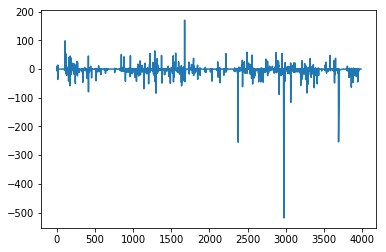

In [37]:
plt.plot(tr1554_events_levels_df.event_mpg.replace([np.inf, -np.inf], np.nan).dropna())
plt.show()

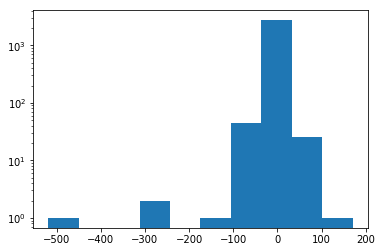

In [38]:
plt.hist(tr1554_events_levels_df.event_mpg.replace([np.inf, -np.inf], np.nan).dropna(),
        log = True)
plt.show()

##### done debugging slice_clean_plot

In [39]:
tr1554_events_levels_df.DriverID = tr1554_events_levels_df.DriverID.astype('str')
tr1554_events_levels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3996 entries, 0 to 3995
Data columns (total 16 columns):
EventTimeStamp       3996 non-null datetime64[ns]
truck                3996 non-null uint32
DriverID             3996 non-null object
Odometer             3996 non-null float64
OdomDiff             3995 non-null float64
TankLevelGallons     3996 non-null float32
GallonsDiff          3995 non-null float32
event_mpg            2937 non-null float64
Speed                3996 non-null uint16
Latitude             3996 non-null float64
Longitude            3996 non-null float64
TankLevelPercent     3996 non-null float32
tankcap              3996 non-null uint16
IgnitionStatus       3996 non-null category
EFReportReason       3996 non-null category
LocationTimeStamp    3996 non-null datetime64[ns]
dtypes: category(2), datetime64[ns](2), float32(3), float64(5), object(1), uint16(2), uint32(1)
memory usage: 335.9+ KB


# Familiarize myself with bokeh

In [40]:
import bokeh
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

In [41]:
p1 = figure(x_axis_type = 'datetime', title = 'Truck 1554 Odometer')
p1.grid.grid_line_alpha = 0.3
p1.axis.axis_label = 'Date'
p1.yaxis.axis_label = 'Odometer'

p1.line(tr1554_events_levels_df.EventTimeStamp, 
        tr1554_events_levels_df.Odometer, color = '#A6CEE3', legend = 'tr1554')
p1.legend.location = "top_left"

tr1554_array = np.array(tr1554_events_levels_df.Odometer)
tr1554_dates_array = np.array(tr1554_events_levels_df.EventTimeStamp)

window_size = 30
window = np.ones(window_size)/float(window_size)
tr1554_avg = np.convolve(tr1554_array, window, 'same')

p2 = figure(x_axis_type = 'datetime', title = 'tr1554 event_mpg')
p2.grid.grid_line_alpha = 0
p2.xaxis.axis_label = 'Date'
p2.yaxis.axis_label = 'event_mpg'
p2.ygrid.band_fill_color = 'olive'
p2.ygrid.band_fill_alpha = 0.1

p2.circle(tr1554_dates_array, tr1554_array, size = 4, legend = 'close',
         color = 'darkgrey', alpha = 0.2)

p2.line(tr1554_array, tr1554_avg, legend = 'avg', color = 'navy')
p2.legend.location = 'top_left'

output_file('tr1554.html', title = 'timeseries.py example')

show(gridplot([[p1, p2]], plot_width = 400, plot_height = 400))

## Familiarize myself with seaborn

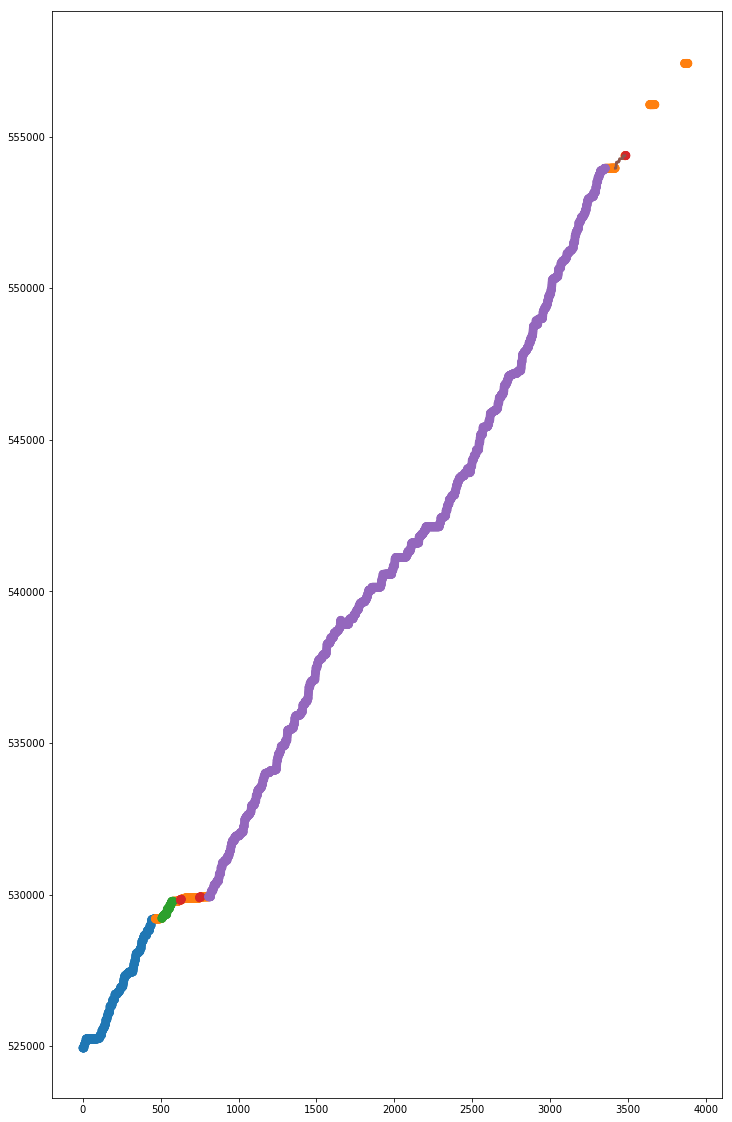

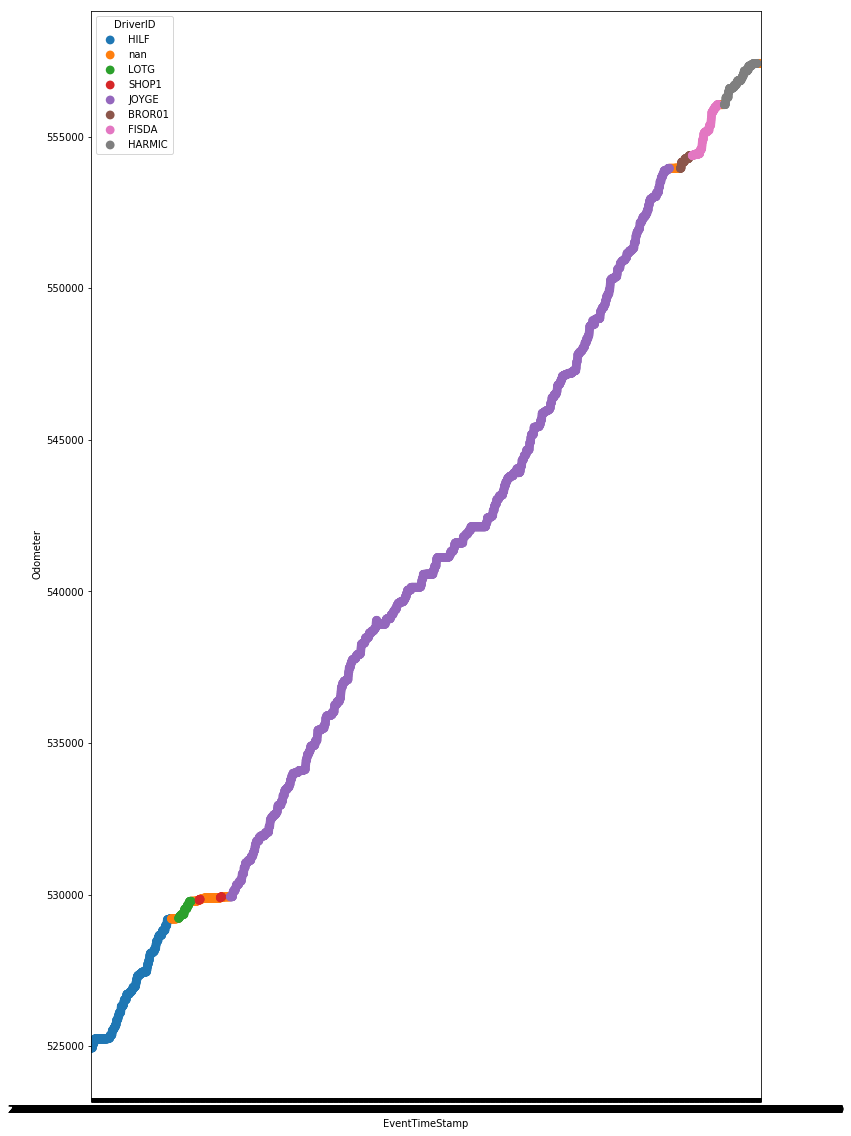

In [43]:
f, ax = plt.subplots(figsize = (20,10))
sns.pointplot(x = 'EventTimeStamp',
             y = 'Odometer',
             hue = 'DriverID',
             data = tr1554_events_levels_df)

#ax.set_xticklabels(rotation = 45, labels = tr1554_events_levels_df[:1000].EventTimeStamp)


plt.show()

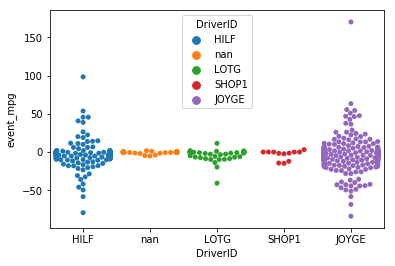

In [44]:
sns.swarmplot(x = 'DriverID',
             y = 'event_mpg',
              hue = 'DriverID',
             data = tr1554_events_levels_df[0:2000])
plt.show()

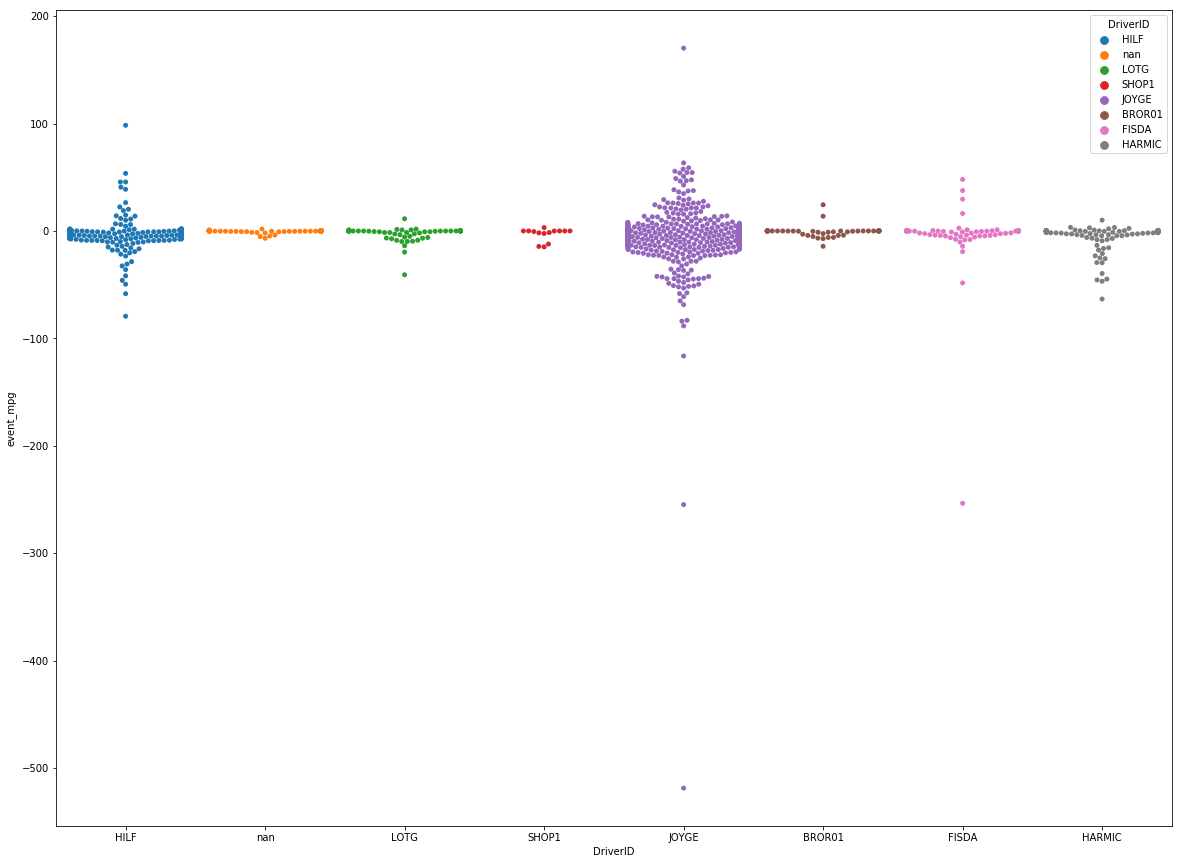

In [45]:
f, ax = plt.subplots(figsize = (20,12))
sns.swarmplot(x = 'DriverID',
             y = 'event_mpg',
              hue = 'DriverID',
             data = tr1554_events_levels_df)
plt.show()

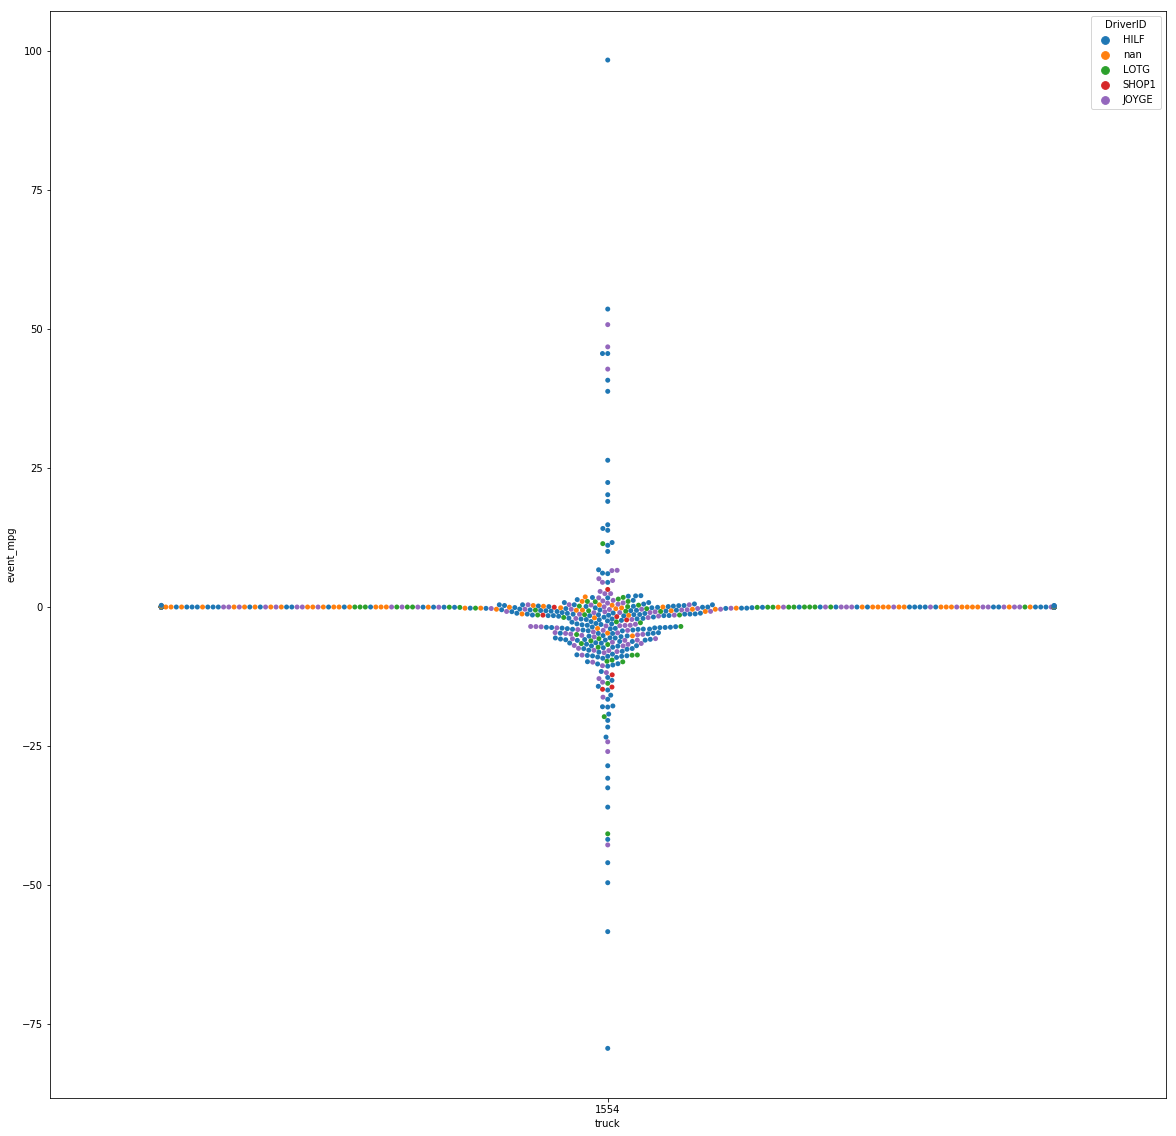

In [46]:
f, ax = plt.subplots(figsize = (20,10))
sns.swarmplot(x = 'truck',
             y = 'event_mpg',
              hue = 'DriverID',
             data = tr1554_events_levels_df[:1000])
plt.show()

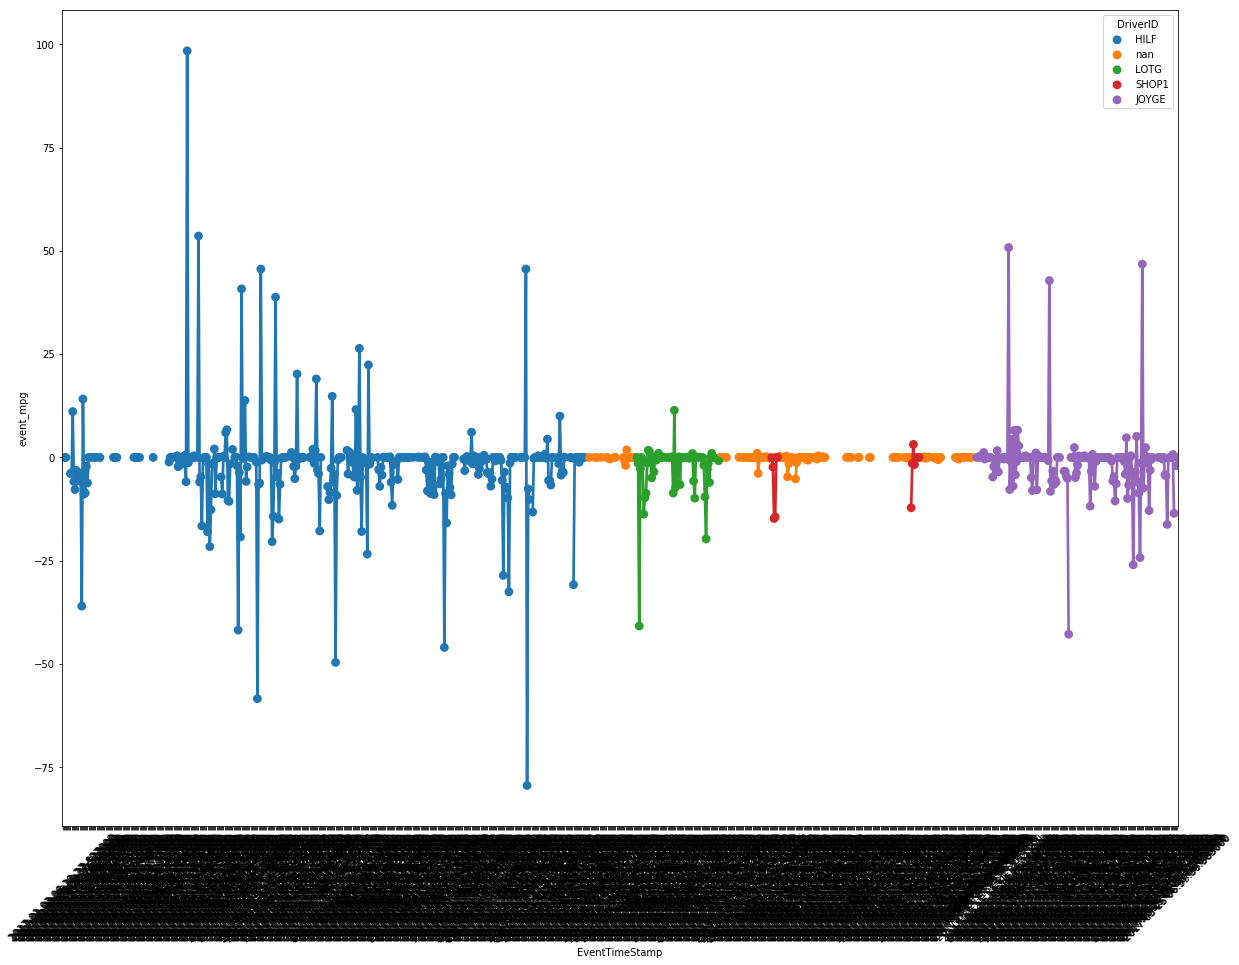

In [47]:
f, ax = plt.subplots(figsize = (20,15))
sns.pointplot(x = 'EventTimeStamp',
             y = 'event_mpg',
             hue = 'DriverID',
             data = tr1554_events_levels_df[:1000])

ax.set_xticklabels(rotation = 45, labels = tr1554_events_levels_df[:1000].EventTimeStamp)


plt.show()

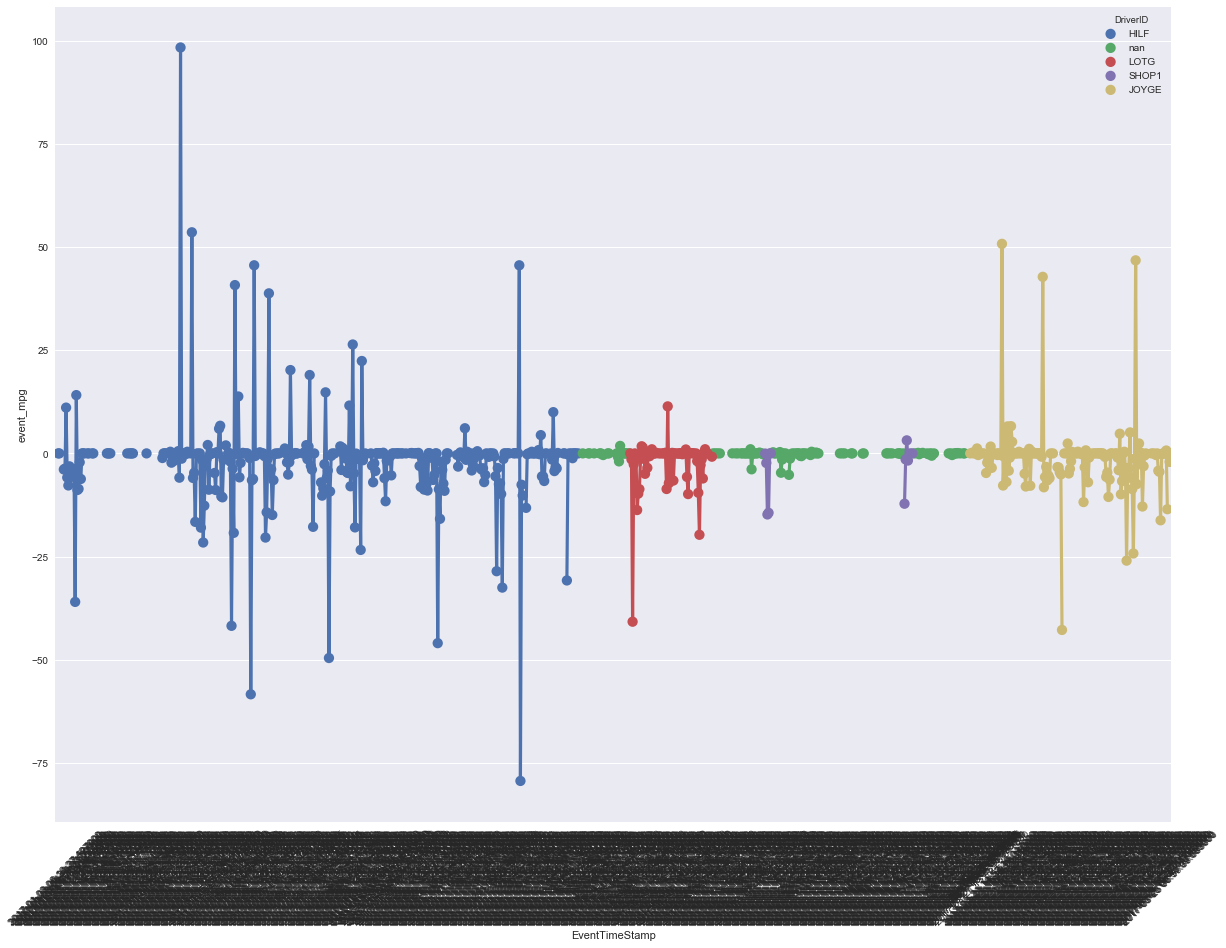

In [48]:
sns.set()
sns.set_style('darkgrid')
sns.set_style('darkgrid', {'xticks.major.size' : 4,
                       'yticks.major.size' : 16})


f, ax = plt.subplots(figsize = (20,15))
sns.pointplot(x = 'EventTimeStamp',
             y = 'event_mpg',
             hue = 'DriverID',
             data = tr1554_events_levels_df[:1000])

ax.set_xticklabels(rotation = 45, labels = tr1554_events_levels_df[:1000].EventTimeStamp)

plt.show()

In [51]:
tips = sns.load_dataset('tips')
titanic = sns.load_dataset("titanic")
iris = sns.load_dataset("iris")

In [50]:
f, ax = plt.subplots(figsize == (5,6))

NameError: name 'figsize' is not defined

In [52]:
sns.set_style('darkgrid')
#sns.set_style('whitegrid')

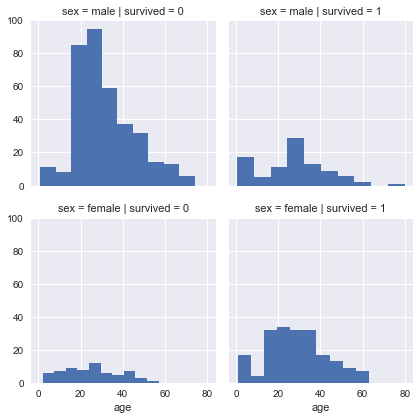

In [53]:
g = sns.FacetGrid(titanic,
                 col = 'survived',
                 row = 'sex')

g = g.map(plt.hist, "age")

plt.show()

In [54]:
tr1554_events_levels_df.DriverID.unique()

array(['HILF', 'nan', 'LOTG', 'SHOP1', 'JOYGE', 'BROR01', 'FISDA', 'HARMIC'], dtype=object)

In [55]:
type(tr1554_events_levels_df.DriverID[0])

str

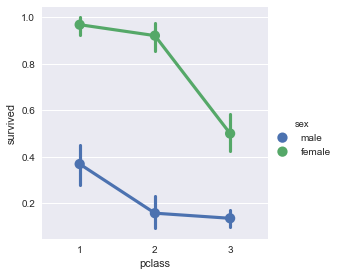

In [56]:
sns.factorplot(x = 'pclass',
               y = 'survived',
               #y = titanic.survived,
              hue = 'sex',
              data = titanic)

plt.show()

In [57]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
embarked       889 non-null object
class          891 non-null category
who            891 non-null object
adult_male     891 non-null bool
deck           203 non-null category
embark_town    889 non-null object
alive          891 non-null object
alone          891 non-null bool
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


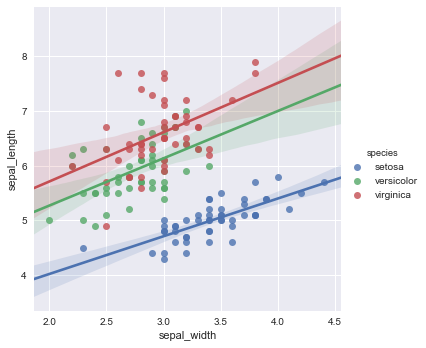

In [58]:
sns.lmplot(x = 'sepal_width',
          y = 'sepal_length',
          hue = 'species',
          data = iris)
plt.show()

# Breaking into plotly

In [59]:
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.graph_objs as go

In [62]:
troublesome_odometers

[1554,
 1558,
 1565,
 1572,
 1579,
 1580,
 1582,
 1597,
 1598,
 1599,
 1626,
 1668,
 1682,
 1771,
 1782,
 1789,
 1849,
 1859,
 1894,
 1899,
 1917,
 1919,
 1924,
 1933,
 1940,
 2011,
 2099]

In [71]:

truck_1554 = Scatter(#marker = ,
    x = tr1554_events_levels_df.EventTimeStamp,
    y = tr1554_events_levels_df.Odometer
)
trace1 = Scatter(#marker = 'o', 
    x = tr1554_events_levels_df.EventTimeStamp,
    y = tr1554_events_levels_df.TankLevelGallons.apply(lambda x: x*2000) #rescale gallons by thousand
    #x = events_levels_df[events_levels_df.truck == 2099][flag_anomal_odom_rows_4(events_levels_df[events_levels_df.truck == 2099])].EventTimeStamp,
    #y = events_levels_df[events_levels_df.truck == 2099][flag_anomal_odom_rows_4(events_levels_df[events_levels_df.truck == 2099])].Odometer
)
data = Data([truck_1554, trace1])
#data = Data([trace0])

py.iplot(data, filename = 'basic-line')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~martipg1/0 or inside your plot.ly account where it is named 'basic-line'


# developing slice_clean_plotly with plotly
😞 not quite working yet

In [72]:
def slice_clean_plotly(df, t, start_date = None, end_date = None, verbose = False, vigilant = False,
                    interactive = False):
    '''Takes an events_levels_df and a specified t = truck and optional date parameters.
    defines that truck's slice, defines the cleaning flags for that slice, 
    plots the data raw and cleaned for visual inspection'''
    
    ##########--- Pending Enhancements ----################
    '''
    To do:
    1. Plot the data before raising vigilance-warnings and asking user to modify the parameters.
        a. I might be able to transfer the "Reporting Results and Handling Special Cases" code 
        from the flag_anomal_odom_rows_4 function.
    2. Plot sns facet grid where each row is a truck and each column is a month.
        a. this should help with the readability of the fuel tank plot
    3.  make use of the date columns?
        a. Ideally I would like to have input sliders that let the user interact with the plot
    '''
    ############----------------------------##############
    
    ######-- Slice 🔪----------------------------------------------------##########
    #make a raw slice for that truck with a fresh index
    t_raw_slice_df = df[df.truck == t].reset_index()
    print('')
    print(" /----------------------------------------------/\\---------------------------------------------------\\")
    print("/--------------------------------------------", t, "---------------------------------------------------\\")

    #---generate cleaning flags for that truck
    flags = flag_anomal_odom_rows_4(t_raw_slice_df[['Odometer', 'truck']], 
                                    verbose = verbose, vigilant = vigilant, interactive = interactive)
    
    ######-- Clean 🛁----------------------------------------------------########
    t_slice_cleaned_df = t_raw_slice_df[flags].reset_index() #### Could combine this snippet with flags above
    
    ####---- Generate Insightful features ⚗️--------------------################
    
    #compute the 
    t_slice_cleaned_df['GallonsDiff'] = t_slice_cleaned_df.TankLevelGallons.diff()
    t_raw_slice_df['GallonsDiff'] = t_raw_slice_df.TankLevelGallons.diff()

    #add the 
    t_slice_cleaned_df['OdomDiff'] = t_slice_cleaned_df.Odometer.diff()
    t_raw_slice_df['OdomDiff'] = t_raw_slice_df.Odometer.diff()
    
    #compute the 
    t_slice_cleaned_df['event_mpg'] = [round(m/g, 2) for m, g in zip(t_slice_cleaned_df.OdomDiff,
                                                                        t_slice_cleaned_df.GallonsDiff)]
    t_raw_slice_df['event_mpg'] = [round(m/g, 2) for m, g in zip(t_raw_slice_df.OdomDiff,
                                                                 t_raw_slice_df.GallonsDiff)]
            
    #####------ Plot 📈------------------------------------------ ############

    # Get this figure: fig = py.get_figure("https://plot.ly/~tarzzz/1992/")
    # Get this figure's data: data = py.get_figure("https://plot.ly/~tarzzz/1992/").get_data()
    # Add data to this figure: py.plot(Data([Scatter(x=[1, 2], y=[2, 3])]), filename ="plot from API (412)", fileopt="extend")
    # Get y data of first trace: y1 = py.get_figure("https://plot.ly/~tarzzz/1992/").get_data()[0]["y"]

    # Get figure documentation: https://plot.ly/python/get-requests/
    # Add data documentation: https://plot.ly/python/file-options/

    # If you're using unicode in your file, you may need to specify the encoding.
    # You can reproduce this figure in Python with the following code!

    # Learn about API authentication here: https://plot.ly/python/getting-started
    # Find your api_key here: https://plot.ly/settings/api
        
    trace1 = Scatter(#marker = ,
        x = t_raw_slice_df.EventTimeStamp,
        y = t_raw_slice_df.Odometer
        )
    trace0 = Scatter(#marker = 'o', 
        x = t_slice_cleaned_df.EventTimeStamp,
        y = t_slice_cleaned_df.TankLevelGallons
        )
    
    data = Data([trace1, trace0])
    
    ''' 
    trace1 = {
        "x" : t_raw_slice_df.Odometer,
        "y" : list(t_raw_slice_df.Odometer),
        "line": {
        "color": "rgba (0, 0, 255, 1)", 
        "dash": "solid",
        "width": 1.0
      }, 
      "mode": "lines", 
      "name": str(t), 
      #"type": 'scatter'
      "xaxis": "x1", 
      "yaxis": "y1"
    }
    trace2 = {
        "x" : t_slice_cleaned_df.EventTimeStamp,
        "y" : t_slice_cleaned_df.Odometer,
        "line": {
        "color": "rgba (0, 0, 255, 1)", 
        "dash": "solid", 
        "width": 1.0
      }, 
      "mode": "lines", 
      "name": "_line0", 
      "type": "scatter", 
      "xaxis": "x2", 
      "yaxis": "y2"
    }
    trace3 = {
        "x" : t_slice_cleaned_df.EventTimeStamp,
        "y" : t_slice_cleaned_df.TankLevelGallons,
        "line": {
        "color": "rgba (0, 0, 255, 1)", 
        "dash": "solid", 
        "width": 1.0
      }, 
      "mode": "lines", 
      "name": "_line0", 
      "type": "scatter", 
      "xaxis": "x3", 
      "yaxis": "y3"
    }
    
    data = Data([trace1, trace2, trace3])
    '''
    
    layout = {
      "autosize": False, 
      "height": 480, 
      "hovermode": "closest", 
      "margin": {
        "r": 63, 
        "t": 47, 
        "b": 47, 
        "l": 80, 
        "pad": 0
      }, 
      "showlegend": True, 
      "width": 640, 
      "xaxis1": {
        "anchor": "y1", 
        "domain": [0.0, 1.0], 
        "mirror": "ticks", 
        "nticks": 6, 
        "range": [0.01, 5.0], 
        "showgrid": False, 
        "showline": True, 
        "side": "bottom", 
        "tickfont": {"size": 6.0}, 
        "ticks": "inside", 
        "type": "linear", 
        "zeroline": False
      }, 
      "xaxis2": {
        "anchor": "y2", 
        "domain": [0.0, 1.0], 
        "mirror": "ticks", 
        "nticks": 6, 
        "range": [0.01, 5.0], 
        "showgrid": True, 
        "showline": True, 
        "side": "bottom", 
        "tickfont": {"size": 12.0}, 
        "ticks": "inside", 
        "type": "linear", 
        "zeroline": True
      }, 
      "xaxis3": {
        "anchor": "y3", 
        "domain": [0.0, 1.0], 
        "mirror": "ticks", 
        "nticks": 6, 
        "range": [0.01, 5.0], 
        "showgrid": True, 
        "showline": True, 
        "side": "bottom", 
        "tickfont": {"size": 12.0}, 
        "ticks": "inside", 
        "type": "linear", 
        "zeroline": False
      }, 
      "yaxis1": {
        "anchor": "x1", 
        "domain": [0.705882352941, 1.0], 
        "mirror": "ticks", 
        "nticks": 5, 
        "range": [-1.0, 1.0], 
        "showgrid": True, 
        "showline": True, 
        "side": "left", 
        "tickfont": {"size": 12.0}, 
        "ticks": "inside", 
        "type": "linear", 
        "zeroline": False
      }, 
      "yaxis2": {
        "anchor": "x2", 
        "domain": [0.352941176471, 0.647058823529], 
        "mirror": "ticks", 
        "nticks": 6, 
        "range": [0.0, 1.0], 
        "showgrid": True, 
        "showline": True, 
        "side": "left", 
        "tickfont": {"size": 12.0}, 
        "ticks": "inside", 
        "type": "linear", 
        "zeroline": False
      }, 
      "yaxis3": {
        "anchor": "x3", 
        "domain": [0.0, 0.294117647059], 
        "mirror": "ticks", 
        "nticks": 5, 
        "range": [-1.0, 1.0], 
        "showgrid": True, 
        "showline": True, 
        "side": "left", 
        "tickfont": {"size": 12.0}, 
        "ticks": "inside", 
        "type": "linear", 
        "zeroline": False
      }
    }
    fig = Figure(data=data, layout=layout)
    #plot_url = py.plot(fig)
    py.iplot(fig)

    #py.iplot(data, filename = 'basic-line')

In [73]:
for t in troublesome_odometers[0:2]:
    trace0 = Scatter(#marker = ,
        x = events_levels_df[events_levels_df.truck == t].EventTimeStamp,
        y = events_levels_df[events_levels_df.truck == t].Odometer
    )
    trace1 = Scatter(#marker = 'o', 
        x = events_levels_df[events_levels_df.truck == t].EventTimeStamp,
        y = events_levels_df[events_levels_df.truck == t].TankLevelGallons
    )
    data = Data([trace0, trace1])
    #data = Data([trace0])

    py.iplot(data, filename = 'basic-line')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~martipg1/0 or inside your plot.ly account where it is named 'basic-line'
High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~martipg1/0 or inside your plot.ly account where it is named 'basic-line'


In [74]:
for t in troublesome_odometers[:1]:
    slice_clean_plotly(events_levels_df, t, verbose = True, vigilant = True, interactive = False)


 /----------------------------------------------/\---------------------------------------------------\
/-------------------------------------------- 1554 ---------------------------------------------------\
2018-05-07 17:36:13.060893 commencing flaging function (by reseting index).

-- set margin to Odometer.diff().std() =  8320.83

-- entering loop at  2018-05-07 17:36:13.062346
truck  1554  entered anomaly at i = 3468 2018-05-07 17:36:13.205305
truck  

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning:

invalid value encountered in double_scalars

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning:

invalid value encountered in double_scalars

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning:

divide by zero encountered in double_scalars



1554  exited anomaly at i= 3473 2018-05-07 17:36:13.206326
------------------
flagged  5 for removal.
That is:  0.12 % of  4001 raw rows.

With a margin of discrimination of :::::::::::::: 8320.83

print completed flagging function at  2018-05-07 17:36:13.222565 flagging took:  0:00:00.161676


### https://plot.ly/~martipg1/0/

# looking into aggregating

In [75]:
[d.date() for d in tr1554_events_levels_df.EventTimeStamp[:10]]

[datetime.date(2017, 1, 3),
 datetime.date(2017, 1, 3),
 datetime.date(2017, 1, 3),
 datetime.date(2017, 1, 3),
 datetime.date(2017, 1, 3),
 datetime.date(2017, 1, 3),
 datetime.date(2017, 1, 3),
 datetime.date(2017, 1, 3),
 datetime.date(2017, 1, 3),
 datetime.date(2017, 1, 3)]

In [76]:
datetime.date(tr1554_events_levels_df.EventTimeStamp[:10])

TypeError: descriptor 'date' requires a 'datetime.datetime' object but received a 'Series'